# Imports

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.0 MB/s eta 0:00:00


In [2]:
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into

In [1]:
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Import the necessary libraries after ensuring numpy and scipy are compatible
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from itertools import permutations
from sklearn.cluster import KMeans

import requests
import heapq
import csv
import os

from sklearn.cluster import KMeans
# numpy is already imported above

from codecarbon import EmissionsTracker
import time
ox.settings.use_cache = True
ox.settings.log_console = False

In [2]:
!pip install k-means-constrained

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take

In [3]:
from k_means_constrained import KMeansConstrained

In [4]:
from codecarbon import EmissionsTracker
import time

ox.settings.use_cache = True
ox.settings.log_console = True

# Functions

## Clusters

In [5]:
def create_clusters(df, n_clusters, alg="k-means"):
  coords = np.array(df[['Lat', 'Lon']].values)

  if(alg == "k-means"):
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=n_clusters)
    labels = kmeans.fit_predict(coords)

  if(alg == "k-means-constrained"):
    # KMeans clustering
    cluster_size = len(coords) // n_clusters

    kmeans = KMeansConstrained(
        n_clusters=n_clusters,
        size_min=cluster_size,
        size_max=cluster_size + 1,
        random_state=0
    )
    labels = kmeans.fit_predict(coords)

  if(alg == "random"):
    labels = np.random.randint(0, n_clusters, len(coords))

  # Para cada cluster, vamos pegar os índices dos pontos
  clusters = [[] for _ in range(10)]
  for idx, label in enumerate(labels):
      clusters[label].append(idx)

  return clusters

In [6]:
def find_nodes(G, clusters, df):
  coords = np.array(df[['Lat', 'Lon']].values)
  nodes = []
  for cluster in clusters:
    cluster_node = []
    lat_lon = coords[cluster]  # Coordenadas do grupo
    lats = lat_lon[:, 1]
    lons = lat_lon[:, 0]

    for i in range(len(lats)):
      cluster_node.append(ox.distance.nearest_nodes(G, X=lons[i], Y=lats[i]))
    nodes.append(cluster_node)
  return nodes

## A*, Dijkstra and min-heap Dijkstra

In [7]:
def dijkstra_traditional(G, source, target):
    """Implementação tradicional do Dijkstra (sem min-heap)."""
    print("iniciou")
    unvisited = set(G.nodes)
    distances = {node: float('inf') for node in G.nodes}
    predecessors = {node: None for node in G.nodes}

    distances[source] = 0

    while unvisited:
        # Seleciona o nó com a menor distância entre os não visitados
        u = min((node for node in unvisited), key=lambda node: distances[node])

        if distances[u] == float('inf'):
            break  # Todos os nós restantes são inalcançáveis

        unvisited.remove(u)

        if u == target:
            # Reconstrói o caminho a partir dos predecessores
            path = []
            while u is not None:
                path.insert(0, u)
                u = predecessors[u]
            return path

        for v in G.successors(u):
            if v in unvisited:
                for key in G[u][v]:
                    length = G[u][v][key].get("length", 1)
                    alt = distances[u] + length
                    if alt < distances[v]:
                        distances[v] = alt
                        predecessors[v] = u

    return None  # Caso não encontre caminho

In [8]:
def calculate_path_distance(G, caminho):
    distancia_total = 0

    for u, v in zip(caminho[:-1], caminho[1:]):
        edge_data = G.get_edge_data(u, v)

        if edge_data is None:
            continue  # Ou você pode fazer: return None ou lançar um erro

        # Para grafos multigrafo, edge_data é um dicionário com 1 ou mais arestas
        # Ex: {0: {'length': x}, 1: {'length': y}}
        lengths = [d['length'] for d in edge_data.values() if 'length' in d]

        if lengths:
            distancia_total += min(lengths)  # Ou sum(lengths), dependendo da lógica
        else:
            continue  # Ou tratar com valor padrão

    return distancia_total

In [9]:
def dijkstra_with_heap(G, source, target):
    """Implementação manual do Dijkstra com min-heap."""
    visited = set()
    min_heap = [(0, source, [])]  # (distância acumulada, nó atual, caminho)

    while min_heap:
        dist_u, u, path = heapq.heappop(min_heap)

        if u in visited:
            continue
        visited.add(u)
        path = path + [u]

        if u == target:
            return path

        for v in G.successors(u):
            if v not in visited:
                for key in G[u][v]:
                    length = G[u][v][key].get("length", 1)
                    heapq.heappush(min_heap, (dist_u + length, v, path))

    return None  # Caso não encontre caminho

In [10]:
def find_route_per_groupe(G, orig_node, dest_nodes, alg="a*"):
    copy_orig_node = orig_node
    route = []        # Ordem dos destinos visitados
    route_path = []   # Caminho completo (nós percorridos)
    remaining_nodes = dest_nodes.copy()  # Cópia para não modificar a lista original
    total_distance = 0
    tracker = EmissionsTracker() # Coletar pegada de carbono
    tracker.start()
    start = time.time()
    tot = len(remaining_nodes)
    print(f"Total de pontos: {tot}")

    while len(remaining_nodes) > 0:
        print(f"Pontos restantes: {len(remaining_nodes)}")
        dists = []
        paths = []

        for node in remaining_nodes:
            print(f"Destino: {node}")
            if alg == "a*":
                path = nx.astar_path(G, orig_node, node, weight='length')
            elif alg == "dijkstra":
                path = dijkstra_traditional(G, orig_node, node)
            elif alg == "dijkstra_heap":
                path = dijkstra_with_heap(G, orig_node, node)
                if path is None:
                    print("Deu ruim")
                    continue
            else:
                raise ValueError("Algoritmo não suportado: use 'a*', 'dijkstra' ou 'dijkstra_heap'.")

            dist = calculate_path_distance(G, path)
            dists.append(dist)
            paths.append(path)

        if not dists:
            break  # Nenhum caminho válido encontrado

        # Escolhe o destino mais próximo
        min_index = dists.index(min(dists))
        nearest_node = remaining_nodes[min_index]
        best_path = paths[min_index]

        # Adiciona à rota final
        route.append(nearest_node)
        # Adiciona à distância ao total
        total_distance += min(dists)

        # Adiciona o caminho ao route_path, evitando repetir o nó inicial
        if not route_path:
            route_path.extend(best_path)
        else:
            route_path.extend(best_path[1:])  # evita repetição do último nó do trecho anterior

        # Atualiza o ponto de partida
        orig_node = nearest_node

        # Remove o destino já visitado da cópia
        remaining_nodes.pop(min_index)

    #calcula o retorno ao nó inicial
    if alg == "a*":
        path = nx.astar_path(G, orig_node, copy_orig_node, weight='length')
    elif alg == "dijkstra":
        path = dijkstra_traditional(G, orig_node, copy_orig_node)
    elif alg == "dijkstra_heap":
        path = dijkstra_with_heap(G, orig_node, copy_orig_node)
    else:
        raise ValueError("Algoritmo não suportado: use 'a*', 'dijkstra' ou 'dijkstra_heap'.")

    # Adiciona o caminho ao route_path, evitando repetir o nó inicial

    route_path.extend(path[1:])  # evita repetição do último nó do trecho anterior
    total_distance += calculate_path_distance(G, path)
    emission = tracker.stop()
    end = time.time()
    tempo = end - start

    return route, route_path, total_distance, emission, tempo

In [11]:
def find_all_goupe_routes(G, orig_node, grupe_nodes, alg="a*"):

  #Armazena a sequência de nós percorridos pelos grupos
  routes = []
  #Armazena todos os pontos do caminho percorridos pelos grupos
  routes_paths = []
  #Armazena a distância de cada grupo
  distances = []
  #Armazena as emissões de carbono
  emissions = []
  #Armazena tempo
  tempos = []

  grupo = 1
  for nodes in grupe_nodes:

    print(f"Grupo {grupo} de {len(grupe_nodes)}")
    grupo += 1

    route, route_path, total_distance, emission, tempo = find_route_per_groupe(G, orig_node, nodes, alg)
    routes.append((route, route_path))
    routes_paths.append(route_path)
    distances.append(total_distance)
    emissions.append(emission)
    tempos.append(tempo)

  return routes, routes_paths, distances, emissions, tempos

## Plots

In [12]:
def plot_clusters(G, clusters, orig_coords, df, title=""):
  # Extrair coordenadas dos pontos
  coords = df[['Lat', 'Lon']].values  # OSMnx usa (lat, lon)

  # Gerar cores diferentes para os grupos
  colors = list(mcolors.TABLEAU_COLORS.values())[:len(clusters)]
  #mudando cores
  colors[2] = "#3BE001"
  colors[7] = "#BDE6BB"

  # Plotar o grafo
  fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(10, 10), node_size=0, edge_color='gray')

  ax.scatter(orig_coords[1], orig_coords[0], c='w', label='origem', s=50, alpha=0.8, edgecolors='k')

  # Para cada grupo, plotar os pontos
  for i, grupo in enumerate(clusters):
      lat_lon = coords[grupo]  # Coordenadas do grupo
      lats = lat_lon[:, 1]
      lons = lat_lon[:, 0]

      ax.scatter(lons, lats, c=colors[i], label=f'Grupo {i+1}', s=50, alpha=0.8, edgecolors='k')


  # Configurações do gráfico
  plt.legend()
  plt.title(title)
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.show()

In [13]:
def plot_clusters_and_routes(G, clusters, routes, orig_coords, df, title='Rotas e Clusters no Grafo', filename='rotas_clusters'):
    # Extrair coordenadas (lat, lon) do dataframe
    coords = df[['Lat', 'Lon']].values

    # Cores distintas para até 10 clusters
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    base_colors[2] = "#3BE001"
    base_colors[7] = "#BDE6BB"

    if len(clusters) > len(base_colors):
        cmap = cm.get_cmap('tab20', len(clusters))
        cluster_colors = [cmap(i) for i in range(len(clusters))]
    else:
        cluster_colors = base_colors[:len(clusters)]

    route_colors = cluster_colors

    # Criar figura e eixo
    fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(16, 16), edge_color='gray', node_size=0)

    # Plota rotas individualmente
    for route, color in zip(routes, route_colors):
        for u, v in zip(route[:-1], route[1:]):
            data = G.get_edge_data(u, v)
            if data is None:
                data = G.get_edge_data(v, u)
                if data is None:
                    continue

            edge = min(data.values(), key=lambda d: d.get("length", float("inf")))
            if "geometry" in edge:
                xs, ys = edge["geometry"].xy
            else:
                xs = [G.nodes[u]['x'], G.nodes[v]['x']]
                ys = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(xs, ys, color=color, linewidth=3, alpha=0.7, zorder=2)

    # Plota a origem
    ax.scatter(orig_coords[1], orig_coords[0], c='white', label='Origem', s=60, alpha=0.9, edgecolors='k', zorder=3)

    # Plota clusters
    for i, grupo in enumerate(clusters):
        lat_lon = coords[grupo]
        lats = lat_lon[:, 1]
        lons = lat_lon[:, 0]

        ax.scatter(
            lons,
            lats,
            c=[cluster_colors[i]],
            label=f'Grupo {i+1}',
            s=50,
            alpha=0.9,
            edgecolors='k',
            zorder=3
        )

    # Configurações visuais
    plt.legend()
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Salvar como PNG e PDF
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    plt.close(fig)


In [14]:
def plot_points_in_graph(G, pontos):
    """
    Plota pontos (latitude, longitude) sobre o grafo G.
    """
    # Extrai as coordenadas dos nós do grafo
    fig, ax = ox.plot_graph(G, show=False, close=False)

    # Separa as listas de latitude e longitude
    lats = [lat for lat, lon in pontos]
    lons = [lon for lat, lon in pontos]

    # Plota os pontos sobre o grafo
    ax.scatter(lons, lats, c='red', s=50, marker='o', label='Pontos')

    plt.legend()
    plt.show()

## Auxiliares

In [15]:
def return_nodes_position(G, nodes):
    """
    Retorna as posições geográficas (latitude e longitude) de uma lista de nós do grafo G.
    """
    positions = []
    for node in nodes:
        if node in G.nodes:
            lat = G.nodes[node]['y']
            lon = G.nodes[node]['x']
            positions.append((lat, lon))
        else:
            print(f"Nó {node} não encontrado no grafo.")
    return positions

# Create Graph

In [16]:
left, bottom, right, top = -35.3150, -5.8850, -35.1700, -5.7000

# Importando o grafo a partir da bounding box
G = ox.graph_from_bbox(bbox = (left, bottom, right, top), network_type='drive')

In [17]:
# Estabelecimento da origem no grafo
orig_coords = (-5.753265931760308, -35.26269411137159) # Unidade de Vigilancia de Zoonoses Natal
orig_node = ox.distance.nearest_nodes(G, X=orig_coords[1], Y=orig_coords[0]) #Encontrando o nó mais próximo a unidade

# Clusters

In [18]:
# Substitua 'arquivo.csv' pelo caminho do seu arquivo
df = pd.read_csv('centroid_filtered.csv')

# Mostrar as primeiras linhas do arquivo
df.head()

,Lon,Lat,Neighborhood,District
0,-5.790850,-35.209797,Alecrim,East
1,-5.796285,-35.196730,Tirol,East
2,-5.788262,-35.190320,Areia Preta,East
3,-5.780528,-35.204124,Ribeira,East
4,-5.767820,-35.200720,Santos Reis,East


In [20]:
clusters_kmeans = create_clusters(df, 10, "k-means")
clusters_kmeans_constrained = create_clusters(df, 10, "k-means-constrained")
clusters_random = create_clusters(df, 10, "random")

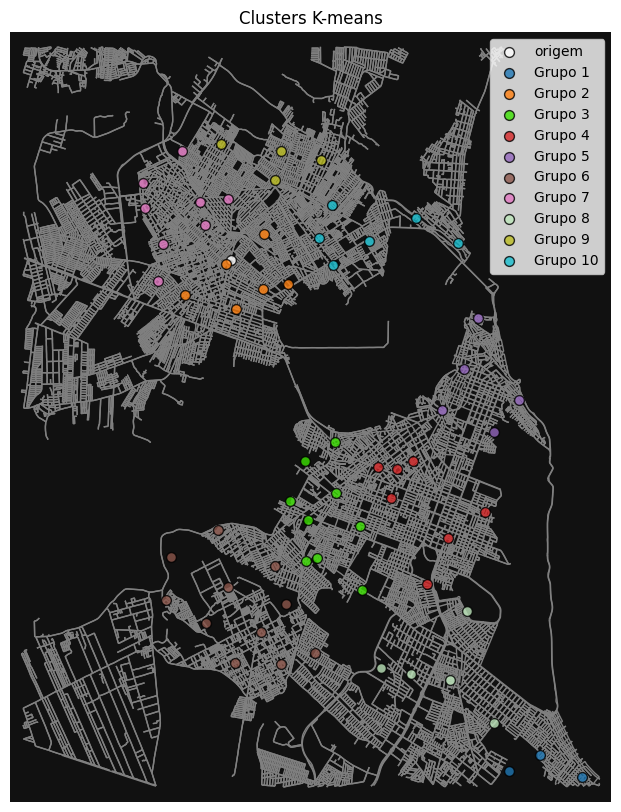

In [ ]:
plot_clusters(G, clusters_kmeans, orig_coords, df, title="Clusters K-means")

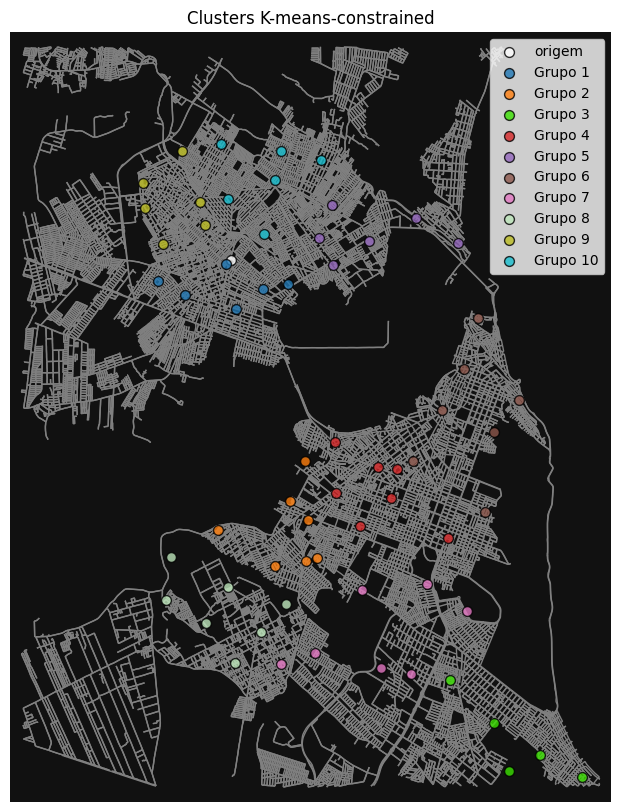

In [ ]:
plot_clusters(G, clusters_kmeans_constrained, orig_coords, df, title="Clusters K-means-constrained")

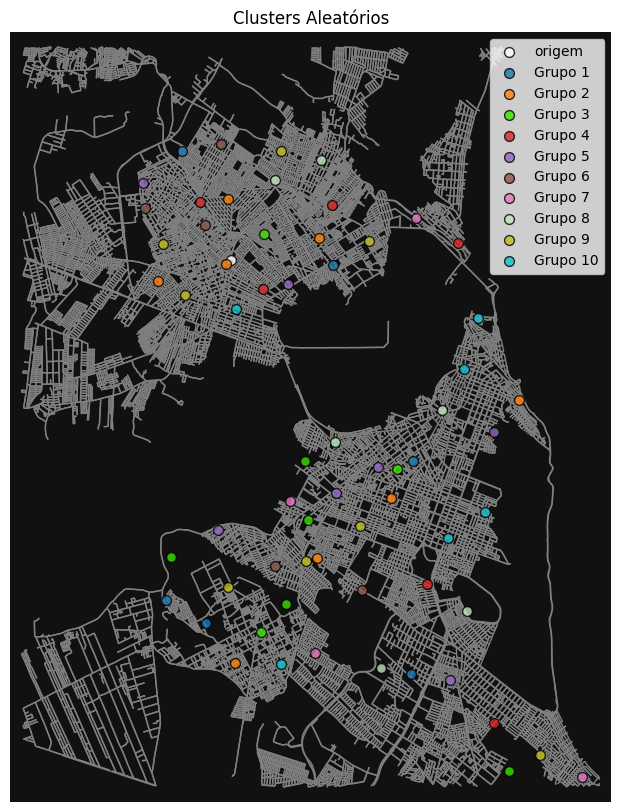

In [ ]:
plot_clusters(G, clusters_random, orig_coords, df, title="Clusters Aleatórios")

In [21]:
nodes_kmeans = find_nodes(G, clusters_kmeans, df)
nodes_kmeans_constrained = find_nodes(G, clusters_kmeans_constrained, df)
nodes_random = find_nodes(G, clusters_random, df)

In [ ]:
path = nx.astar_path(G, orig_node, nodes_kmeans[0][0] , weight='length')

# A*

In [22]:
points1, paths1, distances1, emissions1, times1 = find_all_goupe_routes(G, orig_node, nodes_kmeans, alg="a*")
points2, paths2, distances2, emissions2, times2 = find_all_goupe_routes(G, orig_node, nodes_kmeans_constrained, alg="a*")
points3, paths3, distances3, emissions3, times3 = find_all_goupe_routes(G, orig_node, nodes_random, alg="a*")

[codecarbon WARNING @ 15:46:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:07] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:07] [setup] CPU Tracking...


Grupo 1 de 10


[codecarbon WARNING @ 15:46:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:08] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:09] No GPU found.
[codecarbon INFO @ 15:46:09] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:09] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:09]   Platform system: Linux-6

Total de pontos: 4
Pontos restantes: 4
Destino: 621172350
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 3
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 2
Destino: 3761054921
Destino: 3556620054
Pontos restantes: 1
Destino: 3556620054


[codecarbon INFO @ 15:46:11] Energy consumed for RAM : 0.000007 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:11] Delta energy consumed for CPU with constant : 0.000031 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:11] Energy consumed for All CPU : 0.000031 kWh
[codecarbon INFO @ 15:46:11] 0.000039 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:11] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:11] [setup] CPU Tracking...


Grupo 2 de 10


[codecarbon WARNING @ 15:46:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:13] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:13] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:13] No GPU found.
[codecarbon INFO @ 15:46:13] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:13] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:13]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 9457010544
Destino: 582071896
Destino: 582091997
Destino: 1938124169
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 5
Destino: 9457010544
Destino: 582071896
Destino: 1938124169
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 4
Destino: 9457010544
Destino: 1938124169
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 3
Destino: 1938124169
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 2
Destino: 1938124169
Destino: 3800981858
Pontos restantes: 1
Destino: 1938124169


[codecarbon INFO @ 15:46:14] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:14] Delta energy consumed for CPU with constant : 0.000008 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:14] Energy consumed for All CPU : 0.000008 kWh
[codecarbon INFO @ 15:46:14] 0.000010 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:14] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:14] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:14] [setup] CPU Tracking...


Grupo 3 de 10


[codecarbon WARNING @ 15:46:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:15] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:15] No GPU found.
[codecarbon INFO @ 15:46:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:16] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:16]   Platform system: Linux-6

Total de pontos: 9
Pontos restantes: 9
Destino: 6977211428
Destino: 1121742318
Destino: 1826924707
Destino: 535298925
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 8
Destino: 1121742318
Destino: 1826924707
Destino: 535298925
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 7
Destino: 1121742318
Destino: 1826924707
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 6
Destino: 1826924707
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 5
Destino: 1826924707
Destino: 535253597
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 4
Destino: 1826924707
Destino: 535253597
Destino: 1826425266
Destino: 8925972212
Pontos restantes: 3
Destino: 1826924707
Destino: 535253597
Destino: 8925972212
Pontos restant

[codecarbon INFO @ 15:46:17] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:17] Delta energy consumed for CPU with constant : 0.000020 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:17] Energy consumed for All CPU : 0.000020 kWh
[codecarbon INFO @ 15:46:17] 0.000025 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:17] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:17] [setup] CPU Tracking...


Destino: 8925972212
Pontos restantes: 1
Destino: 535253597
Grupo 4 de 10


[codecarbon WARNING @ 15:46:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:19] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:19] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:19] No GPU found.
[codecarbon INFO @ 15:46:19] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:19] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:19]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 529774092
Destino: 1121742991
Destino: 529723126
Destino: 504801604
Destino: 504801815
Destino: 5264233334
Destino: 505086705
Pontos restantes: 6
Destino: 529774092
Destino: 529723126
Destino: 504801604
Destino: 504801815
Destino: 5264233334
Destino: 505086705
Pontos restantes: 5
Destino: 529774092
Destino: 529723126
Destino: 504801604
Destino: 504801815
Destino: 505086705
Pontos restantes: 4
Destino: 529774092
Destino: 504801604
Destino: 504801815
Destino: 505086705
Pontos restantes: 3
Destino: 504801604
Destino: 504801815
Destino: 505086705
Pontos restantes: 2
Destino: 504801815
Destino: 505086705
Pontos restantes: 1
Destino: 505086705


[codecarbon INFO @ 15:46:21] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:21] Delta energy consumed for CPU with constant : 0.000023 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:21] Energy consumed for All CPU : 0.000023 kWh
[codecarbon INFO @ 15:46:21] 0.000028 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:21] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:21] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:21] [setup] CPU Tracking...


Grupo 5 de 10


[codecarbon WARNING @ 15:46:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:22] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:22] No GPU found.
[codecarbon INFO @ 15:46:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:22] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:22]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Destino: 301375923
Pontos restantes: 4
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Pontos restantes: 3
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Pontos restantes: 2
Destino: 529712802
Destino: 9813580907
Pontos restantes: 1
Destino: 9813580907


[codecarbon INFO @ 15:46:24] Energy consumed for RAM : 0.000004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:24] Delta energy consumed for CPU with constant : 0.000017 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:24] Energy consumed for All CPU : 0.000017 kWh
[codecarbon INFO @ 15:46:24] 0.000021 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:24] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:24] [setup] CPU Tracking...


Grupo 6 de 10


[codecarbon WARNING @ 15:46:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:25] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:25] No GPU found.
[codecarbon INFO @ 15:46:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:25] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:25]   Platform system: Linux-6

Total de pontos: 11
Pontos restantes: 11
Destino: 616061939
Destino: 502777643
Destino: 6157816861
Destino: 3801240873
Destino: 558074811
Destino: 8547312577
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801240722
Pontos restantes: 10
Destino: 502777643
Destino: 6157816861
Destino: 3801240873
Destino: 558074811
Destino: 8547312577
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801240722
Pontos restantes: 9
Destino: 502777643
Destino: 6157816861
Destino: 3801240873
Destino: 558074811
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801240722
Pontos restantes: 8
Destino: 502777643
Destino: 3801240873
Destino: 558074811
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801240722
Pontos restantes: 7
Destino: 502777643
Destino: 3801240873
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801

[codecarbon INFO @ 15:46:28] Energy consumed for RAM : 0.000008 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:28] Delta energy consumed for CPU with constant : 0.000033 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:28] Energy consumed for All CPU : 0.000033 kWh
[codecarbon INFO @ 15:46:28] 0.000040 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:28] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:28] [setup] CPU Tracking...


Grupo 7 de 10


[codecarbon WARNING @ 15:46:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:30] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:30] No GPU found.
[codecarbon INFO @ 15:46:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:30] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:30]   Platform system: Linux-6

Total de pontos: 8
Pontos restantes: 8
Destino: 3800898866
Destino: 544491672
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Destino: 582091990
Pontos restantes: 7
Destino: 544491672
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Destino: 582091990
Pontos restantes: 6
Destino: 544491672
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Pontos restantes: 5
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Pontos restantes: 4
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Pontos restantes: 3
Destino: 3239752030
Destino: 3239765316
Destino: 583262020


[codecarbon INFO @ 15:46:30] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:30] Delta energy consumed for CPU with constant : 0.000009 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:30] Energy consumed for All CPU : 0.000009 kWh
[codecarbon INFO @ 15:46:30] 0.000011 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:30] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:30] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:30] [setup] CPU Tracking...


Pontos restantes: 2
Destino: 3239765316
Destino: 583262020
Pontos restantes: 1
Destino: 583262020
Grupo 8 de 10


[codecarbon WARNING @ 15:46:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:32] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:32] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:32] No GPU found.
[codecarbon INFO @ 15:46:32] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:32] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:32]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 1387156481
Destino: 503277355
Destino: 501895413
Destino: 535397665
Destino: 706783159
Pontos restantes: 4
Destino: 503277355
Destino: 501895413
Destino: 535397665
Destino: 706783159
Pontos restantes: 3
Destino: 501895413
Destino: 535397665
Destino: 706783159
Pontos restantes: 2
Destino: 501895413
Destino: 706783159
Pontos restantes: 1
Destino: 501895413


[codecarbon INFO @ 15:46:33] Energy consumed for RAM : 0.000004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:33] Delta energy consumed for CPU with constant : 0.000018 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:33] Energy consumed for All CPU : 0.000018 kWh
[codecarbon INFO @ 15:46:33] 0.000022 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:33] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:33] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:33] [setup] CPU Tracking...


Grupo 9 de 10


[codecarbon WARNING @ 15:46:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:35] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:35] No GPU found.
[codecarbon INFO @ 15:46:35] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:35] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:35]   Platform system: Linux-6

Total de pontos: 4
Pontos restantes: 4
Destino: 544095252
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 3
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 2
Destino: 3800882767


[codecarbon INFO @ 15:46:35] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:35] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:35] Energy consumed for All CPU : 0.000003 kWh
[codecarbon INFO @ 15:46:35] 0.000004 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:35] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:35] [setup] CPU Tracking...


Destino: 544117306
Pontos restantes: 1
Destino: 3800882767
Grupo 10 de 10


[codecarbon WARNING @ 15:46:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:36] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:36] No GPU found.
[codecarbon INFO @ 15:46:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:36] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:36]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 7012559068
Destino: 535467093
Destino: 1876936852
Pontos restantes: 5
Destino: 505814913
Destino: 3684921709
Destino: 6114434140


[codecarbon INFO @ 15:46:37] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:37] Delta energy consumed for CPU with constant : 0.000007 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:37] Energy consumed for All CPU : 0.000007 kWh
[codecarbon INFO @ 15:46:37] 0.000008 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:37] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:37] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:37] [setup] CPU Tracking...


Destino: 7012559068
Destino: 1876936852
Pontos restantes: 4
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 1876936852
Pontos restantes: 3
Destino: 505814913
Destino: 3684921709
Destino: 1876936852
Pontos restantes: 2
Destino: 505814913
Destino: 1876936852
Pontos restantes: 1
Destino: 1876936852
Grupo 1 de 10


[codecarbon WARNING @ 15:46:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:38] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:38] No GPU found.
[codecarbon INFO @ 15:46:38] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:38] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:38]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 9457010544
Destino: 582071896
Destino: 582091997
Destino: 583262020
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 5
Destino: 9457010544
Destino: 582071896
Destino: 583262020
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 4
Destino: 9457010544
Destino: 583262020
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 3
Destino: 583262020


[codecarbon INFO @ 15:46:39] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:39] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:39] Energy consumed for All CPU : 0.000003 kWh
[codecarbon INFO @ 15:46:39] 0.000004 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:39] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:39] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:39] [setup] CPU Tracking...


Destino: 3800981858
Destino: 7262511226
Pontos restantes: 2
Destino: 583262020
Destino: 3800981858
Pontos restantes: 1
Destino: 583262020
Grupo 2 de 10


[codecarbon WARNING @ 15:46:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:40] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:40] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:40] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:40] No GPU found.
[codecarbon INFO @ 15:46:40] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:40] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:40]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 535298925
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 616061939
Destino: 1826425303
Destino: 3801240722
Pontos restantes: 6
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 616061939
Destino: 1826425303
Destino: 3801240722
Pontos restantes: 5
Destino: 503455939
Destino: 1826425266
Destino: 616061939
Destino: 1826425303
Destino: 3801240722
Pontos restantes: 4
Destino: 1826425266
Destino: 616061939
Destino: 1826425303
Destino: 3801240722
Pontos restantes: 3
Destino: 1826425266
Destino: 616061939
Destino: 3801240722
Pontos restantes: 2
Destino: 616061939
Destino: 3801240722


[codecarbon INFO @ 15:46:41] Energy consumed for RAM : 0.000003 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:41] Delta energy consumed for CPU with constant : 0.000013 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:41] Energy consumed for All CPU : 0.000013 kWh
[codecarbon INFO @ 15:46:41] 0.000016 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:41] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:41] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:41] [setup] CPU Tracking...


Pontos restantes: 1
Destino: 3801240722
Grupo 3 de 10


[codecarbon WARNING @ 15:46:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:43] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:43] No GPU found.
[codecarbon INFO @ 15:46:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:43] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:43]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 503277355
Destino: 501895413
Destino: 621172350
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 5
Destino: 501895413
Destino: 621172350
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 4
Destino: 621172350
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 3
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 2
Destino: 3761054921
Destino: 3556620054
Pontos restantes: 1
Destino: 3556620054


[codecarbon INFO @ 15:46:44] Energy consumed for RAM : 0.000004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:44] Delta energy consumed for CPU with constant : 0.000019 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:44] Energy consumed for All CPU : 0.000019 kWh
[codecarbon INFO @ 15:46:44] 0.000023 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:44] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:44] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:44] [setup] CPU Tracking...


Grupo 4 de 10


[codecarbon WARNING @ 15:46:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:46] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:46] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:46] No GPU found.
[codecarbon INFO @ 15:46:46] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:46] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:46]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 6977211428
Destino: 1121742318
Destino: 1826924707
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 5264233334
Pontos restantes: 6
Destino: 1121742318
Destino: 1826924707
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 5264233334
Pontos restantes: 5
Destino: 1121742318
Destino: 1826924707
Destino: 529774092
Destino: 504801604
Destino: 5264233334
Pontos restantes: 4
Destino: 1121742318
Destino: 1826924707
Destino: 529774092
Destino: 504801604
Pontos restantes: 3
Destino: 1121742318
Destino: 1826924707
Destino: 504801604
Pontos restantes: 2
Destino: 1121742318
Destino: 504801604
Pontos restantes: 1
Destino: 504801604


[codecarbon INFO @ 15:46:48] Energy consumed for RAM : 0.000004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:48] Delta energy consumed for CPU with constant : 0.000019 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:48] Energy consumed for All CPU : 0.000019 kWh
[codecarbon INFO @ 15:46:48] 0.000024 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:48] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:48] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:48] [setup] CPU Tracking...


Grupo 5 de 10


[codecarbon WARNING @ 15:46:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:49] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:49] No GPU found.
[codecarbon INFO @ 15:46:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:49] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:49]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 7012559068
Destino: 535467093
Destino: 1876936852
Pontos restantes: 5
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 7012559068
Destino: 1876936852
Pontos restantes: 4
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 1876936852
Pontos restantes: 3
Destino: 505814913


[codecarbon INFO @ 15:46:49] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:49] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:49] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 15:46:49] 0.000008 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:49] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:49] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:49] [setup] CPU Tracking...


Destino: 3684921709
Destino: 1876936852
Pontos restantes: 2
Destino: 505814913
Destino: 1876936852
Pontos restantes: 1
Destino: 1876936852
Grupo 6 de 10


[codecarbon WARNING @ 15:46:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:51] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:51] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:51] No GPU found.
[codecarbon INFO @ 15:46:51] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:51] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:51]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Destino: 301375923
Destino: 529723126
Destino: 504801815
Pontos restantes: 6
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Destino: 301375923
Destino: 504801815
Pontos restantes: 5
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Destino: 301375923
Destino: 504801815


[codecarbon INFO @ 15:46:52] Energy consumed for RAM : 0.000004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:52] Delta energy consumed for CPU with constant : 0.000015 kWh, power : 42.5 W


Pontos restantes: 4
Destino: 529712802
Destino: 9813580907
Destino: 301375923
Destino: 504801815
Pontos restantes: 3
Destino: 529712802
Destino: 9813580907
Destino: 504801815
Pontos restantes: 2
Destino: 529712802
Destino: 504801815
Pontos restantes: 1
Destino: 504801815


[codecarbon INFO @ 15:46:52] Energy consumed for All CPU : 0.000015 kWh
[codecarbon INFO @ 15:46:52] 0.000019 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:52] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:52] [setup] CPU Tracking...


Grupo 7 de 10


[codecarbon WARNING @ 15:46:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:53] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:53] No GPU found.
[codecarbon INFO @ 15:46:53] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:53] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:53]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 8925972212
Destino: 505086705
Destino: 1387156481
Destino: 535397665
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 6
Destino: 505086705
Destino: 1387156481
Destino: 535397665
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 5
Destino: 1387156481
Destino: 535397665
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 4
Destino: 535397665
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 3
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 2
Destino: 502777643
Destino: 558074811


[codecarbon INFO @ 15:46:55] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:55] Delta energy consumed for CPU with constant : 0.000020 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:55] Energy consumed for All CPU : 0.000020 kWh
[codecarbon INFO @ 15:46:55] 0.000025 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:55] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:55] [setup] CPU Tracking...


Pontos restantes: 1
Destino: 558074811
Grupo 8 de 10


[codecarbon WARNING @ 15:46:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:46:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:46:56] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:46:56] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:46:56] [setup] GPU Tracking...
[codecarbon INFO @ 15:46:56] No GPU found.
[codecarbon INFO @ 15:46:56] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:46:56] >>> Tracker's metadata:
[codecarbon INFO @ 15:46:56]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 6157816861
Destino: 3801240873
Destino: 8547312577
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Pontos restantes: 6
Destino: 6157816861
Destino: 3801240873
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Pontos restantes: 5
Destino: 3801240873
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Pontos restantes: 4
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Pontos restantes: 3
Destino: 3202475506
Destino: 558074964
Destino: 5889519092
Pontos restantes: 2
Destino: 558074964
Destino: 5889519092
Pontos restantes: 1
Destino: 558074964


[codecarbon INFO @ 15:46:58] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:46:58] Delta energy consumed for CPU with constant : 0.000020 kWh, power : 42.5 W
[codecarbon INFO @ 15:46:58] Energy consumed for All CPU : 0.000020 kWh
[codecarbon INFO @ 15:46:58] 0.000025 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:46:58] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:46:58] [setup] RAM Tracking...
[codecarbon INFO @ 15:46:58] [setup] CPU Tracking...


Grupo 9 de 10


[codecarbon WARNING @ 15:47:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:00] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:00] No GPU found.
[codecarbon INFO @ 15:47:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:00] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:00]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 3800898866
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 582091990
Pontos restantes: 5
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 582091990


[codecarbon INFO @ 15:47:00] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:00] Delta energy consumed for CPU with constant : 0.000007 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:00] Energy consumed for All CPU : 0.000007 kWh


Pontos restantes: 4
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Pontos restantes: 3
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Pontos restantes: 2
Destino: 3239752030
Destino: 3239765316
Pontos restantes: 1
Destino: 3239765316


[codecarbon INFO @ 15:47:01] 0.000009 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:01] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:01] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:01] [setup] CPU Tracking...


Grupo 10 de 10


[codecarbon WARNING @ 15:47:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:02] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:02] No GPU found.
[codecarbon INFO @ 15:47:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:02] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:02]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 544491672
Destino: 1938124169
Destino: 544095252
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 5
Destino: 544491672
Destino: 544095252
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 4
Destino: 544491672
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 3
Destino: 544491672


[codecarbon INFO @ 15:47:03] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:03] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:03] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 15:47:03] 0.000007 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:03] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:03] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:03] [setup] CPU Tracking...


Destino: 3800882767
Destino: 544117306
Pontos restantes: 2
Destino: 544491672
Destino: 3800882767
Pontos restantes: 1
Destino: 544491672
Grupo 1 de 10


[codecarbon WARNING @ 15:47:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:04] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:04] No GPU found.
[codecarbon INFO @ 15:47:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:04] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:04]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 529712802
Destino: 9457010544
Destino: 583262020
Destino: 535298925
Destino: 1826425303
Destino: 5889519092
Pontos restantes: 5
Destino: 529712802
Destino: 9457010544
Destino: 535298925
Destino: 1826425303
Destino: 5889519092
Pontos restantes: 4
Destino: 529712802
Destino: 535298925
Destino: 1826425303
Destino: 5889519092
Pontos restantes: 3
Destino: 529712802
Destino: 1826425303
Destino: 5889519092
Pontos restantes: 2
Destino: 529712802
Destino: 5889519092
Pontos restantes: 1
Destino: 529712802


[codecarbon INFO @ 15:47:06] Energy consumed for RAM : 0.000006 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:06] Delta energy consumed for CPU with constant : 0.000026 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:06] Energy consumed for All CPU : 0.000026 kWh
[codecarbon INFO @ 15:47:06] 0.000032 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:06] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:06] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:06] [setup] CPU Tracking...


Grupo 2 de 10


[codecarbon WARNING @ 15:47:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:08] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:08] No GPU found.
[codecarbon INFO @ 15:47:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:08] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:08]   Platform system: Linux-6

Total de pontos: 2
Pontos restantes: 2
Destino: 301375923
Destino: 535467093
Pontos restantes: 1
Destino: 301375923


[codecarbon INFO @ 15:47:08] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:08] Delta energy consumed for CPU with constant : 0.000004 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:08] Energy consumed for All CPU : 0.000004 kWh
[codecarbon INFO @ 15:47:08] 0.000004 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:08] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:08] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:08] [setup] CPU Tracking...


Grupo 3 de 10


[codecarbon WARNING @ 15:47:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:09] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:09] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:09] No GPU found.
[codecarbon INFO @ 15:47:09] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:09] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:09]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 302589698
Destino: 7012559068
Destino: 3239752030
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Destino: 582091990
Pontos restantes: 6
Destino: 302589698
Destino: 7012559068
Destino: 3239752030
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 5
Destino: 302589698
Destino: 7012559068
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 4
Destino: 302589698
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 3
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 2
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 1
Destino: 3801240873


[codecarbon INFO @ 15:47:13] Energy consumed for RAM : 0.000010 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:13] Delta energy consumed for CPU with constant : 0.000044 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:13] Energy consumed for All CPU : 0.000044 kWh
[codecarbon INFO @ 15:47:13] 0.000055 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:13] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:13] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:13] [setup] CPU Tracking...


Grupo 4 de 10


[codecarbon WARNING @ 15:47:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:15] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:15] No GPU found.
[codecarbon INFO @ 15:47:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:15] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:15]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 3239765316
Destino: 1121742318
Destino: 505086705
Destino: 3556620054
Destino: 3801240722
Pontos restantes: 4
Destino: 1121742318
Destino: 505086705
Destino: 3556620054
Destino: 3801240722
Pontos restantes: 3
Destino: 505086705
Destino: 3556620054
Destino: 3801240722
Pontos restantes: 2
Destino: 505086705
Destino: 3556620054


[codecarbon INFO @ 15:47:16] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:16] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:16] Energy consumed for All CPU : 0.000021 kWh
[codecarbon INFO @ 15:47:16] 0.000026 kWh of electricity used since the beginning.


Pontos restantes: 1
Destino: 3556620054


[codecarbon WARNING @ 15:47:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:16] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:16] [setup] CPU Tracking...


Grupo 5 de 10


[codecarbon WARNING @ 15:47:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:18] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:18] No GPU found.
[codecarbon INFO @ 15:47:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:18] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:18]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 544491672
Destino: 1876936852
Destino: 544095252
Destino: 3800981858
Destino: 7262511226
Destino: 8636701382
Destino: 535397665
Pontos restantes: 6
Destino: 544491672
Destino: 1876936852
Destino: 544095252
Destino: 3800981858
Destino: 8636701382
Destino: 535397665
Pontos restantes: 5
Destino: 544491672
Destino: 1876936852
Destino: 544095252
Destino: 8636701382
Destino: 535397665
Pontos restantes: 4
Destino: 1876936852
Destino: 544095252
Destino: 8636701382
Destino: 535397665
Pontos restantes: 3
Destino: 1876936852
Destino: 8636701382
Destino: 535397665
Pontos restantes: 2
Destino: 8636701382
Destino: 535397665
Pontos restantes: 1
Destino: 8636701382


[codecarbon INFO @ 15:47:21] Energy consumed for RAM : 0.000007 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:21] Delta energy consumed for CPU with constant : 0.000032 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:21] Energy consumed for All CPU : 0.000032 kWh
[codecarbon INFO @ 15:47:21] 0.000039 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:21] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:21] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:21] [setup] CPU Tracking...


Grupo 6 de 10


[codecarbon WARNING @ 15:47:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:22] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:22] No GPU found.
[codecarbon INFO @ 15:47:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:22] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:22]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 9813580907
Destino: 6114434140
Destino: 582091997
Destino: 1938124169
Destino: 502777643
Pontos restantes: 4
Destino: 9813580907
Destino: 6114434140
Destino: 1938124169
Destino: 502777643
Pontos restantes: 3
Destino: 9813580907
Destino: 6114434140
Destino: 502777643
Pontos restantes: 2
Destino: 9813580907
Destino: 502777643


[codecarbon INFO @ 15:47:23] Energy consumed for RAM : 0.000004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:23] Delta energy consumed for CPU with constant : 0.000017 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:23] Energy consumed for All CPU : 0.000017 kWh
[codecarbon INFO @ 15:47:23] 0.000021 kWh of electricity used since the beginning.


Pontos restantes: 1
Destino: 502777643


[codecarbon WARNING @ 15:47:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:24] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:24] [setup] CPU Tracking...


Grupo 7 de 10


[codecarbon WARNING @ 15:47:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:25] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:25] No GPU found.
[codecarbon INFO @ 15:47:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:25] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:25]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 301427137
Destino: 1826924707
Destino: 529723126
Destino: 504801815
Destino: 503455939
Destino: 8547312577
Pontos restantes: 5
Destino: 301427137
Destino: 1826924707
Destino: 529723126
Destino: 504801815
Destino: 8547312577
Pontos restantes: 4
Destino: 301427137
Destino: 529723126
Destino: 504801815
Destino: 8547312577
Pontos restantes: 3
Destino: 301427137
Destino: 504801815
Destino: 8547312577
Pontos restantes: 2
Destino: 301427137
Destino: 8547312577
Pontos restantes: 1
Destino: 8547312577


[codecarbon INFO @ 15:47:27] Energy consumed for RAM : 0.000006 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:27] Delta energy consumed for CPU with constant : 0.000025 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:27] Energy consumed for All CPU : 0.000025 kWh
[codecarbon INFO @ 15:47:27] 0.000030 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:27] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:27] [setup] CPU Tracking...


Grupo 8 de 10


[codecarbon WARNING @ 15:47:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:28] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:28] No GPU found.
[codecarbon INFO @ 15:47:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:28] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:28]   Platform system: Linux-6

Total de pontos: 12
Pontos restantes: 12
Destino: 505814913
Destino: 582071896
Destino: 3800898866
Destino: 3800882767
Destino: 544069436
Destino: 6977211428
Destino: 5264233334
Destino: 503277355
Destino: 3761054921
Destino: 706783159
Destino: 6157816861
Destino: 544117306
Pontos restantes: 11
Destino: 505814913
Destino: 3800898866
Destino: 3800882767
Destino: 544069436
Destino: 6977211428
Destino: 5264233334
Destino: 503277355
Destino: 3761054921
Destino: 706783159
Destino: 6157816861
Destino: 544117306
Pontos restantes: 10
Destino: 505814913
Destino: 3800882767
Destino: 544069436
Destino: 6977211428
Destino: 5264233334
Destino: 503277355
Destino: 3761054921
Destino: 706783159
Destino: 6157816861
Destino: 544117306
Pontos restantes: 9
Destino: 505814913
Destino: 3800882767
Destino: 6977211428
Destino: 5264233334
Destino: 503277355
Destino: 3761054921
Destino: 706783159
Destino: 6157816861
Destino: 544117306
Pontos restantes: 8
Destino: 505814913
Destino: 6977211428
Destino: 526423333

[codecarbon INFO @ 15:47:36] Energy consumed for RAM : 0.000021 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:36] Delta energy consumed for CPU with constant : 0.000088 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:36] Energy consumed for All CPU : 0.000088 kWh
[codecarbon INFO @ 15:47:36] 0.000109 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:36] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:36] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:36] [setup] CPU Tracking...


Grupo 9 de 10


[codecarbon WARNING @ 15:47:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:37] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:37] No GPU found.
[codecarbon INFO @ 15:47:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:37] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:37]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 1826425266
Destino: 501895413
Destino: 621172350
Destino: 558074811
Destino: 7024796891
Pontos restantes: 4
Destino: 501895413
Destino: 621172350
Destino: 558074811
Destino: 7024796891
Pontos restantes: 3
Destino: 501895413
Destino: 621172350
Destino: 7024796891
Pontos restantes: 2
Destino: 501895413
Destino: 621172350
Pontos restantes: 1
Destino: 621172350


[codecarbon INFO @ 15:47:40] Energy consumed for RAM : 0.000008 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:40] Delta energy consumed for CPU with constant : 0.000034 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:40] Energy consumed for All CPU : 0.000034 kWh
[codecarbon INFO @ 15:47:40] 0.000042 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:47:40] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:47:40] [setup] RAM Tracking...
[codecarbon INFO @ 15:47:40] [setup] CPU Tracking...


Grupo 10 de 10


[codecarbon WARNING @ 15:47:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:47:42] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:47:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:47:42] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:47:42] [setup] GPU Tracking...
[codecarbon INFO @ 15:47:42] No GPU found.
[codecarbon INFO @ 15:47:42] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:47:42] >>> Tracker's metadata:
[codecarbon INFO @ 15:47:42]   Platform system: Linux-6

Total de pontos: 10
Pontos restantes: 10
Destino: 3684921709
Destino: 3239740862
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Destino: 544095386
Pontos restantes: 9
Destino: 3684921709
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Destino: 544095386
Pontos restantes: 8
Destino: 3684921709
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Pontos restantes: 7
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Pontos restantes: 6
Destino: 529774092
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Pontos restantes: 5
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Des

[codecarbon INFO @ 15:47:48] Energy consumed for RAM : 0.000017 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:47:48] Delta energy consumed for CPU with constant : 0.000074 kWh, power : 42.5 W
[codecarbon INFO @ 15:47:48] Energy consumed for All CPU : 0.000074 kWh
[codecarbon INFO @ 15:47:48] 0.000091 kWh of electricity used since the beginning.


In [23]:
results = pd.DataFrame({
    'distance_astar_kmeans': distances1,
    'emission_astar_kmeans': emissions1,
    'time_astar_kmeans': times1,
    'distance_astar_kmeans_constrained': distances2,
    'emission_astar_kmeans_constrained': emissions2,
    'time_astar_kmeans_constrained': times2,
    'distance_astar_random': distances3,
    'emission_astar_random': emissions3,
    'time_astar_random': times3
})

results.to_csv('dados_astar.csv', index=False)

print(results)

   distance_astar_kmeans  emission_astar_kmeans  time_astar_kmeans  \
0           45025.864891               0.000018           2.666883   
1           11329.762483               0.000004           0.682787   
2           31846.838939               0.000011           1.696314   
3           31736.068379               0.000013           1.941947   
4           31151.546141               0.000009           1.447790   
5           43237.010416               0.000018           2.778549   
6           13326.635364               0.000005           0.744478   
7           41233.748769               0.000010           1.538096   
8           12845.507846               0.000002           0.294931   
9           18313.929637               0.000004           0.580383   

   distance_astar_kmeans_constrained  emission_astar_kmeans_constrained  \
0                        9858.362674                           0.000002   
1                       28725.390257                           0.000007   
2   

In [24]:
plot_clusters_and_routes(G, clusters_kmeans, paths1, orig_coords, df, "ROTAS DO ALGORITMO A* PARA O CLUSTER K-MEANS", "astar_kmeans")
plot_clusters_and_routes(G, clusters_kmeans_constrained, paths2, orig_coords, df, "ROTAS DO ALGORITMO A* PARA O CLUSTER K-MEANS CONSTRAINED", "astar_kmeans_constrained")
plot_clusters_and_routes(G, clusters_random, paths3, orig_coords, df, "ROTAS DO ALGORITMO A* PARA O CLUSTER ALEATÓRIO ", "astar_random")

# Dijkstra min-heap

In [29]:
points1, paths1, distances1, emissions1, times1 = find_all_goupe_routes(G, orig_node, nodes_kmeans, alg="dijkstra_heap")
points2, paths2, distances2, emissions2, times2 = find_all_goupe_routes(G, orig_node, nodes_kmeans_constrained, alg="dijkstra_heap")
points3, paths3, distances3, emissions3, times3 = find_all_goupe_routes(G, orig_node, nodes_random, alg="dijkstra_heap")

[codecarbon WARNING @ 15:56:09] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:09] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:09] [setup] CPU Tracking...


Grupo 1 de 10


[codecarbon WARNING @ 15:56:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:11] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:11] No GPU found.
[codecarbon INFO @ 15:56:11] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:11] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:11]   Platform system: Linux-6

Total de pontos: 4
Pontos restantes: 4
Destino: 621172350
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382


[codecarbon INFO @ 15:56:12] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:12] Delta energy consumed for CPU with constant : 0.000010 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:12] Energy consumed for All CPU : 0.000010 kWh
[codecarbon INFO @ 15:56:12] 0.000012 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:12] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:12] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:12] [setup] CPU Tracking...


Pontos restantes: 3
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 2
Destino: 3761054921
Destino: 3556620054
Pontos restantes: 1
Destino: 3556620054
Grupo 2 de 10


[codecarbon WARNING @ 15:56:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:13] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:13] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:13] No GPU found.
[codecarbon INFO @ 15:56:13] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:13] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:13]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 9457010544
Destino: 582071896
Destino: 582091997
Destino: 1938124169
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 5
Destino: 9457010544
Destino: 582071896
Destino: 1938124169
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 4
Destino: 9457010544
Destino: 1938124169
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 3
Destino: 1938124169
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 2
Destino: 1938124169
Destino: 3800981858
Pontos restantes: 1
Destino: 1938124169


[codecarbon INFO @ 15:56:13] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:13] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:13] Energy consumed for All CPU : 0.000003 kWh
[codecarbon INFO @ 15:56:13] 0.000003 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:13] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:13] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:13] [setup] CPU Tracking...


Grupo 3 de 10


[codecarbon WARNING @ 15:56:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:14] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:14] No GPU found.
[codecarbon INFO @ 15:56:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:14] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:14]   Platform system: Linux-6

Total de pontos: 9
Pontos restantes: 9
Destino: 6977211428
Destino: 1121742318
Destino: 1826924707
Destino: 535298925
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 8
Destino: 1121742318
Destino: 1826924707
Destino: 535298925
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 7
Destino: 1121742318
Destino: 1826924707
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 6
Destino: 1826924707
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 5
Destino: 1826924707
Destino: 535253597
Destino: 1826425266
Destino: 1826425303
Destino: 8925972212
Pontos restantes: 4
Destino: 1826924707
Destino: 535253597
Destino: 1826425266
Destino: 8925972212
Pontos restantes: 3
Destino: 1826924707
Destino: 535253597
Destino: 8925972212
Pontos restant

[codecarbon INFO @ 15:56:16] Energy consumed for RAM : 0.000004 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:16] Delta energy consumed for CPU with constant : 0.000016 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:16] Energy consumed for All CPU : 0.000016 kWh
[codecarbon INFO @ 15:56:16] 0.000020 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:16] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:16] [setup] CPU Tracking...


Grupo 4 de 10


[codecarbon WARNING @ 15:56:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:17] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:17] No GPU found.
[codecarbon INFO @ 15:56:17] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:17] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:17]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 529774092
Destino: 1121742991
Destino: 529723126
Destino: 504801604
Destino: 504801815
Destino: 5264233334
Destino: 505086705
Pontos restantes: 6
Destino: 529774092
Destino: 529723126
Destino: 504801604
Destino: 504801815
Destino: 5264233334
Destino: 505086705
Pontos restantes: 5
Destino: 529774092
Destino: 529723126
Destino: 504801604
Destino: 504801815
Destino: 505086705
Pontos restantes: 4
Destino: 529774092
Destino: 504801604
Destino: 504801815
Destino: 505086705
Pontos restantes: 3
Destino: 504801604
Destino: 504801815
Destino: 505086705


[codecarbon INFO @ 15:56:19] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:19] Delta energy consumed for CPU with constant : 0.000020 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:19] Energy consumed for All CPU : 0.000020 kWh


Pontos restantes: 2
Destino: 504801815
Destino: 505086705
Pontos restantes: 1
Destino: 505086705


[codecarbon INFO @ 15:56:19] 0.000025 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:19] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:19] [setup] CPU Tracking...


Grupo 5 de 10


[codecarbon WARNING @ 15:56:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:20] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:20] No GPU found.
[codecarbon INFO @ 15:56:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:20] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:20]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Destino: 301375923
Pontos restantes: 4
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Pontos restantes: 3
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Pontos restantes: 2
Destino: 529712802
Destino: 9813580907
Pontos restantes: 1
Destino: 9813580907


[codecarbon INFO @ 15:56:21] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:21] Delta energy consumed for CPU with constant : 0.000009 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:21] Energy consumed for All CPU : 0.000009 kWh
[codecarbon INFO @ 15:56:21] 0.000011 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:21] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:21] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:21] [setup] CPU Tracking...


Grupo 6 de 10


[codecarbon WARNING @ 15:56:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:23] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:23] No GPU found.
[codecarbon INFO @ 15:56:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:23] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:23]   Platform system: Linux-6

Total de pontos: 11
Pontos restantes: 11
Destino: 616061939
Destino: 502777643
Destino: 6157816861
Destino: 3801240873
Destino: 558074811
Destino: 8547312577
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801240722
Pontos restantes: 10
Destino: 502777643
Destino: 6157816861
Destino: 3801240873
Destino: 558074811
Destino: 8547312577
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801240722
Pontos restantes: 9
Destino: 502777643
Destino: 6157816861
Destino: 3801240873
Destino: 558074811
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801240722
Pontos restantes: 8
Destino: 502777643
Destino: 3801240873
Destino: 558074811
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801240722
Pontos restantes: 7
Destino: 502777643
Destino: 3801240873
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Destino: 3801

[codecarbon INFO @ 15:56:28] Energy consumed for RAM : 0.000015 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:28] Delta energy consumed for CPU with constant : 0.000064 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:28] Energy consumed for All CPU : 0.000064 kWh
[codecarbon INFO @ 15:56:28] 0.000079 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:28] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:28] [setup] CPU Tracking...


Grupo 7 de 10


[codecarbon WARNING @ 15:56:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:30] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:30] No GPU found.
[codecarbon INFO @ 15:56:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:30] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:30]   Platform system: Linux-6

Total de pontos: 8
Pontos restantes: 8
Destino: 3800898866
Destino: 544491672
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Destino: 582091990
Pontos restantes: 7
Destino: 544491672
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Destino: 582091990
Pontos restantes: 6
Destino: 544491672
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Pontos restantes: 5
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020


[codecarbon INFO @ 15:56:32] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:32] Delta energy consumed for CPU with constant : 0.000022 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:32] Energy consumed for All CPU : 0.000022 kWh
[codecarbon INFO @ 15:56:32] 0.000027 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:32] Multiple instances of codecarbon are allowed to run at the same time.


Pontos restantes: 4
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Pontos restantes: 3
Destino: 3239752030
Destino: 3239765316
Destino: 583262020
Pontos restantes: 2
Destino: 3239765316
Destino: 583262020
Pontos restantes: 1
Destino: 583262020
Grupo 8 de 10


[codecarbon INFO @ 15:56:32] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:32] [setup] CPU Tracking...
[codecarbon WARNING @ 15:56:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:33] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:33] No GPU found.
[codecarbon INFO @ 15:56:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[c

Total de pontos: 5
Pontos restantes: 5
Destino: 1387156481
Destino: 503277355
Destino: 501895413
Destino: 535397665
Destino: 706783159
Pontos restantes: 4
Destino: 503277355
Destino: 501895413
Destino: 535397665
Destino: 706783159
Pontos restantes: 3
Destino: 501895413
Destino: 535397665
Destino: 706783159
Pontos restantes: 2
Destino: 501895413


[codecarbon INFO @ 15:56:34] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:34] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:34] Energy consumed for All CPU : 0.000011 kWh
[codecarbon INFO @ 15:56:34] 0.000013 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:34] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:34] [setup] CPU Tracking...


Destino: 706783159
Pontos restantes: 1
Destino: 501895413
Grupo 9 de 10


[codecarbon WARNING @ 15:56:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:35] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:35] No GPU found.
[codecarbon INFO @ 15:56:35] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:35] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:35]   Platform system: Linux-6

Total de pontos: 4
Pontos restantes: 4
Destino: 544095252
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 3
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 2
Destino: 3800882767
Destino: 544117306
Pontos restantes: 1
Destino: 3800882767


[codecarbon INFO @ 15:56:36] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:36] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:36] Energy consumed for All CPU : 0.000003 kWh
[codecarbon INFO @ 15:56:36] 0.000003 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:36] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:36] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:36] [setup] CPU Tracking...


Grupo 10 de 10


[codecarbon WARNING @ 15:56:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:37] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:37] No GPU found.
[codecarbon INFO @ 15:56:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:37] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:37]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 7012559068
Destino: 535467093
Destino: 1876936852
Pontos restantes: 5
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 7012559068
Destino: 1876936852
Pontos restantes: 4
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 1876936852
Pontos restantes: 3
Destino: 505814913
Destino: 3684921709
Destino: 1876936852


[codecarbon INFO @ 15:56:37] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:37] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:37] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 15:56:37] 0.000007 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:37] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:37] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:37] [setup] CPU Tracking...


Pontos restantes: 2
Destino: 505814913
Destino: 1876936852
Pontos restantes: 1
Destino: 1876936852
Grupo 1 de 10


[codecarbon WARNING @ 15:56:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:39] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:39] No GPU found.
[codecarbon INFO @ 15:56:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:39] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:39]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 9457010544
Destino: 582071896
Destino: 582091997
Destino: 583262020
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 5
Destino: 9457010544
Destino: 582071896
Destino: 583262020
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 4
Destino: 9457010544
Destino: 583262020
Destino: 3800981858
Destino: 7262511226
Pontos restantes: 3
Destino: 583262020
Destino: 3800981858
Destino: 7262511226


[codecarbon INFO @ 15:56:39] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:39] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:39] Energy consumed for All CPU : 0.000003 kWh
[codecarbon INFO @ 15:56:39] 0.000004 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:39] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:39] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:39] [setup] CPU Tracking...


Pontos restantes: 2
Destino: 583262020
Destino: 3800981858
Pontos restantes: 1
Destino: 583262020
Grupo 2 de 10


[codecarbon WARNING @ 15:56:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:40] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:40] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:40] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:40] No GPU found.
[codecarbon INFO @ 15:56:40] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:40] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:40]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 535298925
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 616061939
Destino: 1826425303
Destino: 3801240722
Pontos restantes: 6
Destino: 535253597
Destino: 503455939
Destino: 1826425266
Destino: 616061939
Destino: 1826425303
Destino: 3801240722
Pontos restantes: 5
Destino: 503455939
Destino: 1826425266
Destino: 616061939
Destino: 1826425303
Destino: 3801240722
Pontos restantes: 4
Destino: 1826425266
Destino: 616061939
Destino: 1826425303
Destino: 3801240722
Pontos restantes: 3
Destino: 1826425266
Destino: 616061939
Destino: 3801240722
Pontos restantes: 2
Destino: 616061939
Destino: 3801240722
Pontos restantes: 1
Destino: 3801240722


[codecarbon INFO @ 15:56:42] Energy consumed for RAM : 0.000003 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:42] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:42] Energy consumed for All CPU : 0.000012 kWh
[codecarbon INFO @ 15:56:42] 0.000015 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:42] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:42] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:42] [setup] CPU Tracking...


Grupo 3 de 10


[codecarbon WARNING @ 15:56:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:43] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:43] No GPU found.
[codecarbon INFO @ 15:56:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:43] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:43]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 503277355
Destino: 501895413
Destino: 621172350
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 5
Destino: 501895413
Destino: 621172350
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 4
Destino: 621172350
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 3
Destino: 3761054921
Destino: 3556620054
Destino: 8636701382
Pontos restantes: 2
Destino: 3761054921
Destino: 3556620054
Pontos restantes: 1
Destino: 3556620054


[codecarbon INFO @ 15:56:48] Energy consumed for RAM : 0.000013 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:48] Delta energy consumed for CPU with constant : 0.000057 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:48] Energy consumed for All CPU : 0.000057 kWh
[codecarbon INFO @ 15:56:48] 0.000071 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:48] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:48] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:48] [setup] CPU Tracking...


Grupo 4 de 10


[codecarbon WARNING @ 15:56:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:50] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:50] No GPU found.
[codecarbon INFO @ 15:56:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:50] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:50]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 6977211428
Destino: 1121742318
Destino: 1826924707
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 5264233334
Pontos restantes: 6
Destino: 1121742318
Destino: 1826924707
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 5264233334
Pontos restantes: 5
Destino: 1121742318
Destino: 1826924707
Destino: 529774092
Destino: 504801604
Destino: 5264233334
Pontos restantes: 4
Destino: 1121742318
Destino: 1826924707
Destino: 529774092
Destino: 504801604
Pontos restantes: 3
Destino: 1121742318
Destino: 1826924707
Destino: 504801604
Pontos restantes: 2
Destino: 1121742318
Destino: 504801604
Pontos restantes: 1
Destino: 504801604


[codecarbon INFO @ 15:56:52] Energy consumed for RAM : 0.000006 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:52] Delta energy consumed for CPU with constant : 0.000026 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:52] Energy consumed for All CPU : 0.000026 kWh
[codecarbon INFO @ 15:56:52] 0.000032 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:52] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:52] [setup] CPU Tracking...


Grupo 5 de 10


[codecarbon WARNING @ 15:56:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:54] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:54] No GPU found.
[codecarbon INFO @ 15:56:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:54] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:54]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 7012559068
Destino: 535467093
Destino: 1876936852
Pontos restantes: 5
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 7012559068
Destino: 1876936852
Pontos restantes: 4
Destino: 505814913
Destino: 3684921709
Destino: 6114434140
Destino: 1876936852
Pontos restantes: 3
Destino: 505814913
Destino: 3684921709
Destino: 1876936852
Pontos restantes: 2
Destino: 505814913


[codecarbon INFO @ 15:56:54] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:54] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:54] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 15:56:54] 0.000007 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:56:54] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:54] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:54] [setup] CPU Tracking...


Destino: 1876936852
Pontos restantes: 1
Destino: 1876936852
Grupo 6 de 10


[codecarbon WARNING @ 15:56:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:55] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:55] No GPU found.
[codecarbon INFO @ 15:56:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:55] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:55]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Destino: 301375923
Destino: 529723126
Destino: 504801815
Pontos restantes: 6
Destino: 302589698
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Destino: 301375923
Destino: 504801815
Pontos restantes: 5
Destino: 529712802
Destino: 9813580907
Destino: 301427137
Destino: 301375923
Destino: 504801815
Pontos restantes: 4
Destino: 529712802
Destino: 9813580907


[codecarbon INFO @ 15:56:57] Energy consumed for RAM : 0.000003 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:56:57] Delta energy consumed for CPU with constant : 0.000013 kWh, power : 42.5 W
[codecarbon INFO @ 15:56:57] Energy consumed for All CPU : 0.000013 kWh
[codecarbon INFO @ 15:56:57] 0.000017 kWh of electricity used since the beginning.


Destino: 301375923
Destino: 504801815
Pontos restantes: 3
Destino: 529712802
Destino: 9813580907
Destino: 504801815
Pontos restantes: 2
Destino: 529712802
Destino: 504801815
Pontos restantes: 1
Destino: 504801815


[codecarbon WARNING @ 15:56:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:56:57] [setup] RAM Tracking...
[codecarbon INFO @ 15:56:57] [setup] CPU Tracking...


Grupo 7 de 10


[codecarbon WARNING @ 15:56:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:56:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:56:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:56:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:56:58] [setup] GPU Tracking...
[codecarbon INFO @ 15:56:58] No GPU found.
[codecarbon INFO @ 15:56:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:56:58] >>> Tracker's metadata:
[codecarbon INFO @ 15:56:58]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 8925972212
Destino: 505086705
Destino: 1387156481
Destino: 535397665
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 6
Destino: 505086705
Destino: 1387156481
Destino: 535397665
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 5
Destino: 1387156481
Destino: 535397665
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 4
Destino: 535397665
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 3
Destino: 706783159
Destino: 502777643
Destino: 558074811
Pontos restantes: 2
Destino: 502777643


[codecarbon INFO @ 15:57:00] Energy consumed for RAM : 0.000006 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:00] Delta energy consumed for CPU with constant : 0.000026 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:00] Energy consumed for All CPU : 0.000026 kWh
[codecarbon INFO @ 15:57:00] 0.000032 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:00] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:00] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:00] [setup] CPU Tracking...


Destino: 558074811
Pontos restantes: 1
Destino: 558074811
Grupo 8 de 10


[codecarbon WARNING @ 15:57:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:02] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:02] No GPU found.
[codecarbon INFO @ 15:57:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:02] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:02]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 6157816861
Destino: 3801240873
Destino: 8547312577
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Pontos restantes: 6
Destino: 6157816861
Destino: 3801240873
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092


[codecarbon INFO @ 15:57:03] Energy consumed for RAM : 0.000003 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:03] Delta energy consumed for CPU with constant : 0.000014 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:03] Energy consumed for All CPU : 0.000014 kWh
[codecarbon INFO @ 15:57:03] 0.000018 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:03] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:03] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:03] [setup] CPU Tracking...


Pontos restantes: 5
Destino: 3801240873
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Pontos restantes: 4
Destino: 3202475506
Destino: 7024796891
Destino: 558074964
Destino: 5889519092
Pontos restantes: 3
Destino: 3202475506
Destino: 558074964
Destino: 5889519092
Pontos restantes: 2
Destino: 558074964
Destino: 5889519092
Pontos restantes: 1
Destino: 558074964
Grupo 9 de 10


[codecarbon WARNING @ 15:57:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:04] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:04] No GPU found.
[codecarbon INFO @ 15:57:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:04] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:04]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 3800898866
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316


[codecarbon INFO @ 15:57:05] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:05] Delta energy consumed for CPU with constant : 0.000005 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:05] Energy consumed for All CPU : 0.000005 kWh
[codecarbon INFO @ 15:57:05] 0.000006 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:05] [setup] RAM Tracking...


Destino: 582091990
Pontos restantes: 5
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Destino: 582091990
Pontos restantes: 4
Destino: 544069436
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Pontos restantes: 3
Destino: 3239740862
Destino: 3239752030
Destino: 3239765316
Pontos restantes: 2
Destino: 3239752030
Destino: 3239765316
Pontos restantes: 1
Destino: 3239765316
Grupo 10 de 10


[codecarbon INFO @ 15:57:05] [setup] CPU Tracking...
[codecarbon WARNING @ 15:57:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:06] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:06] No GPU found.
[codecarbon INFO @ 15:57:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:06] >>> Tracker's metadata:
[c

Total de pontos: 6
Pontos restantes: 6
Destino: 544491672
Destino: 1938124169
Destino: 544095252
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 5
Destino: 544491672
Destino: 544095252
Destino: 3800882767


[codecarbon INFO @ 15:57:07] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:07] Delta energy consumed for CPU with constant : 0.000008 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:07] Energy consumed for All CPU : 0.000008 kWh
[codecarbon INFO @ 15:57:07] 0.000010 kWh of electricity used since the beginning.


Destino: 544095386
Destino: 544117306
Pontos restantes: 4
Destino: 544491672
Destino: 3800882767
Destino: 544095386
Destino: 544117306
Pontos restantes: 3
Destino: 544491672
Destino: 3800882767
Destino: 544117306
Pontos restantes: 2
Destino: 544491672
Destino: 3800882767
Pontos restantes: 1
Destino: 544491672


[codecarbon WARNING @ 15:57:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:07] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:07] [setup] CPU Tracking...


Grupo 1 de 10


[codecarbon WARNING @ 15:57:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:08] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:08] No GPU found.
[codecarbon INFO @ 15:57:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:08] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:08]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 529712802
Destino: 9457010544
Destino: 583262020
Destino: 535298925
Destino: 1826425303
Destino: 5889519092
Pontos restantes: 5
Destino: 529712802
Destino: 9457010544
Destino: 535298925
Destino: 1826425303
Destino: 5889519092
Pontos restantes: 4
Destino: 529712802
Destino: 535298925
Destino: 1826425303
Destino: 5889519092
Pontos restantes: 3
Destino: 529712802
Destino: 1826425303
Destino: 5889519092
Pontos restantes: 2
Destino: 529712802
Destino: 5889519092
Pontos restantes: 1
Destino: 529712802


[codecarbon INFO @ 15:57:11] Energy consumed for RAM : 0.000008 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:11] Delta energy consumed for CPU with constant : 0.000033 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:11] Energy consumed for All CPU : 0.000033 kWh
[codecarbon INFO @ 15:57:11] 0.000041 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:11] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:11] [setup] CPU Tracking...


Grupo 2 de 10


[codecarbon WARNING @ 15:57:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:13] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:13] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:13] No GPU found.
[codecarbon INFO @ 15:57:13] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:13] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:13]   Platform system: Linux-6

Total de pontos: 2
Pontos restantes: 2
Destino: 301375923
Destino: 535467093
Pontos restantes: 1
Destino: 301375923


[codecarbon INFO @ 15:57:14] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:14] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:14] Energy consumed for All CPU : 0.000011 kWh
[codecarbon INFO @ 15:57:14] 0.000013 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:14] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:14] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:14] [setup] CPU Tracking...


Grupo 3 de 10


[codecarbon WARNING @ 15:57:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:15] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:15] No GPU found.
[codecarbon INFO @ 15:57:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:15] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:15]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 302589698
Destino: 7012559068
Destino: 3239752030
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Destino: 582091990
Pontos restantes: 6
Destino: 302589698
Destino: 7012559068
Destino: 3239752030
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 5
Destino: 302589698
Destino: 7012559068
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 4
Destino: 302589698
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 3
Destino: 616061939
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 2
Destino: 3801240873
Destino: 3202475506
Pontos restantes: 1
Destino: 3801240873


[codecarbon INFO @ 15:57:19] Energy consumed for RAM : 0.000010 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:19] Delta energy consumed for CPU with constant : 0.000042 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:19] Energy consumed for All CPU : 0.000042 kWh
[codecarbon INFO @ 15:57:19] 0.000051 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:19] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:19] [setup] CPU Tracking...


Grupo 4 de 10


[codecarbon WARNING @ 15:57:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:20] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:20] No GPU found.
[codecarbon INFO @ 15:57:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:20] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:20]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 3239765316
Destino: 1121742318
Destino: 505086705
Destino: 3556620054
Destino: 3801240722
Pontos restantes: 4
Destino: 1121742318
Destino: 505086705
Destino: 3556620054
Destino: 3801240722
Pontos restantes: 3
Destino: 505086705
Destino: 3556620054
Destino: 3801240722
Pontos restantes: 2
Destino: 505086705
Destino: 3556620054
Pontos restantes: 1
Destino: 3556620054


[codecarbon INFO @ 15:57:23] Energy consumed for RAM : 0.000008 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:23] Delta energy consumed for CPU with constant : 0.000033 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:23] Energy consumed for All CPU : 0.000033 kWh
[codecarbon INFO @ 15:57:23] 0.000040 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:23] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:23] [setup] CPU Tracking...


Grupo 5 de 10


[codecarbon WARNING @ 15:57:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:25] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:25] No GPU found.
[codecarbon INFO @ 15:57:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:25] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:25]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 544491672
Destino: 1876936852
Destino: 544095252
Destino: 3800981858
Destino: 7262511226
Destino: 8636701382
Destino: 535397665
Pontos restantes: 6
Destino: 544491672
Destino: 1876936852
Destino: 544095252
Destino: 3800981858
Destino: 8636701382
Destino: 535397665
Pontos restantes: 5
Destino: 544491672
Destino: 1876936852
Destino: 544095252
Destino: 8636701382
Destino: 535397665
Pontos restantes: 4
Destino: 1876936852
Destino: 544095252
Destino: 8636701382
Destino: 535397665
Pontos restantes: 3
Destino: 1876936852
Destino: 8636701382
Destino: 535397665
Pontos restantes: 2
Destino: 8636701382
Destino: 535397665


[codecarbon INFO @ 15:57:28] Energy consumed for RAM : 0.000010 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:28] Delta energy consumed for CPU with constant : 0.000041 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:28] Energy consumed for All CPU : 0.000041 kWh
[codecarbon INFO @ 15:57:28] 0.000051 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:28] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:28] [setup] CPU Tracking...


Pontos restantes: 1
Destino: 8636701382
Grupo 6 de 10


[codecarbon WARNING @ 15:57:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:30] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:30] No GPU found.
[codecarbon INFO @ 15:57:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:30] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:30]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 9813580907
Destino: 6114434140
Destino: 582091997
Destino: 1938124169
Destino: 502777643
Pontos restantes: 4
Destino: 9813580907
Destino: 6114434140
Destino: 1938124169
Destino: 502777643
Pontos restantes: 3
Destino: 9813580907
Destino: 6114434140
Destino: 502777643
Pontos restantes: 2
Destino: 9813580907
Destino: 502777643


[codecarbon INFO @ 15:57:32] Energy consumed for RAM : 0.000007 kWh. RAM Power : 10.0 W


Pontos restantes: 1
Destino: 502777643


[codecarbon INFO @ 15:57:32] Delta energy consumed for CPU with constant : 0.000031 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:32] Energy consumed for All CPU : 0.000031 kWh
[codecarbon INFO @ 15:57:32] 0.000038 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:32] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:32] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:32] [setup] CPU Tracking...


Grupo 7 de 10


[codecarbon WARNING @ 15:57:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:34] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:34] No GPU found.
[codecarbon INFO @ 15:57:34] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:34] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:34]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 301427137
Destino: 1826924707
Destino: 529723126
Destino: 504801815
Destino: 503455939
Destino: 8547312577
Pontos restantes: 5
Destino: 301427137
Destino: 1826924707
Destino: 529723126
Destino: 504801815
Destino: 8547312577
Pontos restantes: 4
Destino: 301427137
Destino: 529723126
Destino: 504801815
Destino: 8547312577
Pontos restantes: 3
Destino: 301427137
Destino: 504801815
Destino: 8547312577
Pontos restantes: 2
Destino: 301427137
Destino: 8547312577
Pontos restantes: 1
Destino: 8547312577


[codecarbon INFO @ 15:57:37] Energy consumed for RAM : 0.000007 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:37] Delta energy consumed for CPU with constant : 0.000031 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:37] Energy consumed for All CPU : 0.000031 kWh
[codecarbon INFO @ 15:57:37] 0.000039 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:37] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:37] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:37] [setup] CPU Tracking...


Grupo 8 de 10


[codecarbon WARNING @ 15:57:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:38] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:38] No GPU found.
[codecarbon INFO @ 15:57:38] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:38] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:38]   Platform system: Linux-6

Total de pontos: 12
Pontos restantes: 12
Destino: 505814913
Destino: 582071896
Destino: 3800898866
Destino: 3800882767
Destino: 544069436
Destino: 6977211428
Destino: 5264233334
Destino: 503277355
Destino: 3761054921
Destino: 706783159
Destino: 6157816861
Destino: 544117306
Pontos restantes: 11
Destino: 505814913
Destino: 3800898866
Destino: 3800882767
Destino: 544069436
Destino: 6977211428
Destino: 5264233334
Destino: 503277355
Destino: 3761054921
Destino: 706783159
Destino: 6157816861
Destino: 544117306
Pontos restantes: 10
Destino: 505814913
Destino: 3800882767
Destino: 544069436
Destino: 6977211428
Destino: 5264233334
Destino: 503277355
Destino: 3761054921
Destino: 706783159
Destino: 6157816861
Destino: 544117306
Pontos restantes: 9
Destino: 505814913
Destino: 3800882767
Destino: 6977211428
Destino: 5264233334
Destino: 503277355
Destino: 3761054921
Destino: 706783159
Destino: 6157816861
Destino: 544117306
Pontos restantes: 8
Destino: 505814913
Destino: 6977211428
Destino: 526423333

[codecarbon INFO @ 15:57:49] Energy consumed for RAM : 0.000029 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:49] Delta energy consumed for CPU with constant : 0.000125 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:49] Energy consumed for All CPU : 0.000125 kWh
[codecarbon INFO @ 15:57:49] 0.000154 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:49] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:49] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:49] [setup] CPU Tracking...


Grupo 9 de 10


[codecarbon WARNING @ 15:57:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:50] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:50] No GPU found.
[codecarbon INFO @ 15:57:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:50] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:50]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 1826425266
Destino: 501895413
Destino: 621172350
Destino: 558074811
Destino: 7024796891
Pontos restantes: 4
Destino: 501895413
Destino: 621172350
Destino: 558074811
Destino: 7024796891
Pontos restantes: 3
Destino: 501895413
Destino: 621172350
Destino: 7024796891
Pontos restantes: 2
Destino: 501895413
Destino: 621172350
Pontos restantes: 1
Destino: 621172350


[codecarbon INFO @ 15:57:54] Energy consumed for RAM : 0.000010 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:57:54] Delta energy consumed for CPU with constant : 0.000042 kWh, power : 42.5 W
[codecarbon INFO @ 15:57:54] Energy consumed for All CPU : 0.000042 kWh
[codecarbon INFO @ 15:57:54] 0.000052 kWh of electricity used since the beginning.
[codecarbon WARNING @ 15:57:54] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:57:54] [setup] RAM Tracking...
[codecarbon INFO @ 15:57:54] [setup] CPU Tracking...


Grupo 10 de 10


[codecarbon WARNING @ 15:57:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:57:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:57:56] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:57:56] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:57:56] [setup] GPU Tracking...
[codecarbon INFO @ 15:57:56] No GPU found.
[codecarbon INFO @ 15:57:56] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 15:57:56] >>> Tracker's metadata:
[codecarbon INFO @ 15:57:56]   Platform system: Linux-6

Total de pontos: 10
Pontos restantes: 10
Destino: 3684921709
Destino: 3239740862
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Destino: 544095386
Pontos restantes: 9
Destino: 3684921709
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Destino: 544095386
Pontos restantes: 8
Destino: 3684921709
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Pontos restantes: 7
Destino: 529774092
Destino: 1121742991
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Pontos restantes: 6
Destino: 529774092
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Destino: 558074964
Pontos restantes: 5
Destino: 504801604
Destino: 535253597
Destino: 8925972212
Destino: 1387156481
Des

[codecarbon INFO @ 15:58:00] Energy consumed for RAM : 0.000012 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:58:00] Delta energy consumed for CPU with constant : 0.000051 kWh, power : 42.5 W
[codecarbon INFO @ 15:58:00] Energy consumed for All CPU : 0.000051 kWh
[codecarbon INFO @ 15:58:00] 0.000063 kWh of electricity used since the beginning.


In [28]:
results = pd.DataFrame({
    'distance_dijkstra_heap_kmeans': distances1,
    'emission_dijkstra_heap_kmeans': emissions1,
    'time_dijkstra_heap_kmeans': times1,
    'distance_dijkstra_heap_kmeans_constrained': distances2,
    'emission_dijkstra_heap_kmeans_constrained': emissions2,
    'time_dijkstra_heap_kmeans_constrained': times2,
    'distance_dijkstra_heap_random': distances3,
    'emission_dijkstra_heap_random': emissions3,
    'time_dijkstra_heap_random': times3
})

results.to_csv('dados_dijkstra_heap.csv', index=False)

print(results)

   distance_dijkstra_heap_kmeans  emission_dijkstra_heap_kmeans  \
0                   45025.864891                       0.000008   
1                   11329.762483                       0.000002   
2                   31846.838939                       0.000009   
3                   31736.068379                       0.000007   
4                   31151.546141                       0.000005   
5                   43237.010416                       0.000021   
6                   13326.635364                       0.000004   
7                   41233.748769                       0.000006   
8                   12845.507846                       0.000001   
9                   18313.929637                       0.000003   

   time_dijkstra_heap_kmeans  distance_dijkstra_heap_kmeans_constrained  \
0                   1.166863                                9858.362674   
1                   0.254342                               28725.390257   
2                   1.334224         

In [30]:
plot_clusters_and_routes(G, clusters_kmeans, paths1, orig_coords, df, "ROTAS DO ALGORITMO DIJKSTRA COM MIN-HEAP PARA O CLUSTER K-MEANS", "dijkstra_heap_kmeans")
plot_clusters_and_routes(G, clusters_kmeans_constrained, paths2, orig_coords, df, "ROTAS DO ALGORITMO DIJKSTRA COM MIN-HEAP PARA O CLUSTER K-MEANS CONSTRAINED", "dijkstra_heap_kmeans_constrained")
plot_clusters_and_routes(G, clusters_random, paths3, orig_coords, df, "ROTAS DO ALGORITMO DIJKSTRA COM MIN-HEAP PARA O CLUSTER ALEATÓRIO ", "dijkstra_heap_random")

## Dijkstra


In [ ]:
points1, paths1, distances1, emissions1, times1 = find_all_goupe_routes(G, orig_node, nodes_kmeans, alg="dijkstra")
#points2, paths2, distances2, emissions2, times2 = find_all_goupe_routes(G, orig_node, nodes_kmeans_constrained, alg="dijkstra")
#points3, paths3, distances3, emissions3, times3 = find_all_goupe_routes(G, orig_node, nodes_random, alg="dijkstra")

[codecarbon WARNING @ 10:10:45] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:10:45] [setup] RAM Tracking...
[codecarbon INFO @ 10:10:45] [setup] CPU Tracking...


Grupo 1 de 10


[codecarbon WARNING @ 10:10:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:10:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:10:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:10:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:10:47] [setup] GPU Tracking...
[codecarbon INFO @ 10:10:47] No GPU found.
[codecarbon INFO @ 10:10:47] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:10:47] >>> Tracker's metadata:
[codecarbon INFO @ 10:10:47]   Platform system: Linux-6

Total de pontos: 4
Pontos restantes: 4
Destino: 621172350
iniciou


[codecarbon INFO @ 10:11:02] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:11:02] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:11:02] Energy consumed for All CPU : 0.000178 kWh
[codecarbon INFO @ 10:11:02] 0.000219 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:17] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:11:17] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:11:17] Energy consumed for All CPU : 0.000355 kWh
[codecarbon INFO @ 10:11:17] 0.000439 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:32] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:11:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:11:32] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 10:11:32] 0.000657 kWh 

Destino: 3761054921
iniciou


[codecarbon INFO @ 10:12:47] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:12:47] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:12:47] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 10:12:47] 0.001749 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:12:47] 0.002020 g.CO2eq/s mean an estimation of 63.692839379636986 kg.CO2eq/year
[codecarbon INFO @ 10:13:02] Energy consumed for RAM : 0.000374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:13:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:13:02] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 10:13:02] 0.001967 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:13:17] Energy consumed for RAM : 0.000416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:13:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon

Destino: 3556620054
iniciou


[codecarbon INFO @ 10:14:47] Energy consumed for RAM : 0.000665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:14:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:14:47] Energy consumed for All CPU : 0.002830 kWh
[codecarbon INFO @ 10:14:47] 0.003495 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:14:47] 0.002017 g.CO2eq/s mean an estimation of 63.61718390294126 kg.CO2eq/year
[codecarbon INFO @ 10:15:02] Energy consumed for RAM : 0.000706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:15:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:15:02] Energy consumed for All CPU : 0.003007 kWh
[codecarbon INFO @ 10:15:02] 0.003713 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:17] Energy consumed for RAM : 0.000748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:15:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Destino: 8636701382
iniciou


[codecarbon INFO @ 10:16:32] Energy consumed for RAM : 0.000956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:16:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:32] Energy consumed for All CPU : 0.004068 kWh
[codecarbon INFO @ 10:16:32] 0.005024 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:47] Energy consumed for RAM : 0.000997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:16:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:47] Energy consumed for All CPU : 0.004245 kWh
[codecarbon INFO @ 10:16:47] 0.005242 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:47] 0.002020 g.CO2eq/s mean an estimation of 63.69192654756411 kg.CO2eq/year
[codecarbon INFO @ 10:17:02] Energy consumed for RAM : 0.001039 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:17:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Pontos restantes: 3
Destino: 3761054921
iniciou


[codecarbon INFO @ 10:18:32] Energy consumed for RAM : 0.001288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:18:32] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:18:32] Energy consumed for All CPU : 0.005483 kWh
[codecarbon INFO @ 10:18:32] 0.006771 kWh of electricity used since the beginning.


Destino: 3556620054
iniciou


[codecarbon INFO @ 10:18:47] Energy consumed for RAM : 0.001330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:18:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:18:47] Energy consumed for All CPU : 0.005661 kWh
[codecarbon INFO @ 10:18:47] 0.006990 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:18:47] 0.002020 g.CO2eq/s mean an estimation of 63.69609360412739 kg.CO2eq/year
[codecarbon INFO @ 10:19:02] Energy consumed for RAM : 0.001371 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:19:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:19:02] Energy consumed for All CPU : 0.005838 kWh
[codecarbon INFO @ 10:19:02] 0.007209 kWh of electricity used since the beginning.


Destino: 8636701382
iniciou


[codecarbon INFO @ 10:19:17] Energy consumed for RAM : 0.001413 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:19:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:19:17] Energy consumed for All CPU : 0.006014 kWh
[codecarbon INFO @ 10:19:17] 0.007427 kWh of electricity used since the beginning.


Pontos restantes: 2
Destino: 3761054921
iniciou
Destino: 3556620054
iniciou


[codecarbon INFO @ 10:19:32] Energy consumed for RAM : 0.001454 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:19:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:19:32] Energy consumed for All CPU : 0.006191 kWh
[codecarbon INFO @ 10:19:32] 0.007646 kWh of electricity used since the beginning.


Pontos restantes: 1
Destino: 3556620054
iniciou
iniciou


[codecarbon INFO @ 10:19:47] Energy consumed for RAM : 0.001496 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:19:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:19:47] Energy consumed for All CPU : 0.006368 kWh
[codecarbon INFO @ 10:19:47] 0.007864 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:02] Energy consumed for RAM : 0.001538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:20:02] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:20:02] Energy consumed for All CPU : 0.006546 kWh
[codecarbon INFO @ 10:20:02] 0.008083 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:17] Energy consumed for RAM : 0.001579 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:20:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:20:17] Energy consumed for All CPU : 0.006722 kWh
[codecarbon INFO @ 10:20:17] 0.008302 kWh 

Grupo 2 de 10


[codecarbon WARNING @ 10:21:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:21:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:21:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:21:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:21:11] [setup] GPU Tracking...
[codecarbon INFO @ 10:21:11] No GPU found.
[codecarbon INFO @ 10:21:11] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:21:11] >>> Tracker's metadata:
[codecarbon INFO @ 10:21:11]   Platform system: Linux-6

Total de pontos: 6
Pontos restantes: 6
Destino: 9457010544
iniciou


[codecarbon INFO @ 10:21:27] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:21:27] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:21:27] Energy consumed for All CPU : 0.000178 kWh
[codecarbon INFO @ 10:21:27] 0.000219 kWh of electricity used since the beginning.


Destino: 582071896
iniciou


[codecarbon INFO @ 10:21:42] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:21:42] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:21:42] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:21:42] 0.000438 kWh of electricity used since the beginning.


Destino: 582091997
iniciou
Destino: 1938124169
iniciou


[codecarbon INFO @ 10:21:57] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:21:57] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:21:57] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 10:21:57] 0.000657 kWh of electricity used since the beginning.


Destino: 3800981858
iniciou
Destino: 7262511226
iniciou


[codecarbon INFO @ 10:22:12] Energy consumed for RAM : 0.000166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:22:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:22:12] Energy consumed for All CPU : 0.000709 kWh
[codecarbon INFO @ 10:22:12] 0.000875 kWh of electricity used since the beginning.


Pontos restantes: 5
Destino: 9457010544
iniciou


[codecarbon INFO @ 10:22:27] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:22:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:22:27] Energy consumed for All CPU : 0.000886 kWh
[codecarbon INFO @ 10:22:27] 0.001094 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:22:42] Energy consumed for RAM : 0.000249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:22:42] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:22:42] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 10:22:42] 0.001312 kWh of electricity used since the beginning.


Destino: 582071896
iniciou
Destino: 1938124169
iniciou


[codecarbon INFO @ 10:22:57] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:22:57] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:22:57] Energy consumed for All CPU : 0.001238 kWh
[codecarbon INFO @ 10:22:57] 0.001529 kWh of electricity used since the beginning.


Destino: 3800981858
iniciou


[codecarbon INFO @ 10:23:12] Energy consumed for RAM : 0.000332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:23:12] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:23:12] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 10:23:12] 0.001748 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:23:12] 0.002019 g.CO2eq/s mean an estimation of 63.66459422644378 kg.CO2eq/year


Destino: 7262511226
iniciou


[codecarbon INFO @ 10:23:27] Energy consumed for RAM : 0.000374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:23:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:23:27] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 10:23:27] 0.001966 kWh of electricity used since the beginning.


Pontos restantes: 4
Destino: 9457010544
iniciou
Destino: 1938124169
iniciou


[codecarbon INFO @ 10:23:42] Energy consumed for RAM : 0.000415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:23:42] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:23:42] Energy consumed for All CPU : 0.001769 kWh
[codecarbon INFO @ 10:23:42] 0.002184 kWh of electricity used since the beginning.


Destino: 3800981858
iniciou


[codecarbon INFO @ 10:23:57] Energy consumed for RAM : 0.000457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:23:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:23:57] Energy consumed for All CPU : 0.001946 kWh
[codecarbon INFO @ 10:23:57] 0.002403 kWh of electricity used since the beginning.


Destino: 7262511226
iniciou
Pontos restantes: 3
Destino: 1938124169
iniciou


[codecarbon INFO @ 10:24:12] Energy consumed for RAM : 0.000499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:24:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:24:12] Energy consumed for All CPU : 0.002123 kWh
[codecarbon INFO @ 10:24:12] 0.002621 kWh of electricity used since the beginning.


Destino: 3800981858
iniciou


[codecarbon INFO @ 10:24:27] Energy consumed for RAM : 0.000540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:24:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:24:27] Energy consumed for All CPU : 0.002300 kWh
[codecarbon INFO @ 10:24:27] 0.002840 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:24:42] Energy consumed for RAM : 0.000582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:24:42] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:24:42] Energy consumed for All CPU : 0.002477 kWh
[codecarbon INFO @ 10:24:42] 0.003059 kWh of electricity used since the beginning.


Destino: 7262511226
iniciou


[codecarbon INFO @ 10:24:57] Energy consumed for RAM : 0.000623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:24:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:24:57] Energy consumed for All CPU : 0.002654 kWh
[codecarbon INFO @ 10:24:57] 0.003277 kWh of electricity used since the beginning.


Pontos restantes: 2
Destino: 1938124169
iniciou


[codecarbon INFO @ 10:25:12] Energy consumed for RAM : 0.000665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:25:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:25:12] Energy consumed for All CPU : 0.002831 kWh
[codecarbon INFO @ 10:25:12] 0.003496 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:12] 0.002019 g.CO2eq/s mean an estimation of 63.68443494996577 kg.CO2eq/year


Destino: 3800981858
iniciou


[codecarbon INFO @ 10:25:27] Energy consumed for RAM : 0.000706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:25:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:25:27] Energy consumed for All CPU : 0.003007 kWh
[codecarbon INFO @ 10:25:27] 0.003714 kWh of electricity used since the beginning.


Pontos restantes: 1
Destino: 1938124169
iniciou


[codecarbon INFO @ 10:25:42] Energy consumed for RAM : 0.000748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:25:42] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:25:42] Energy consumed for All CPU : 0.003185 kWh
[codecarbon INFO @ 10:25:42] 0.003933 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:57] Energy consumed for RAM : 0.000790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:25:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:25:57] Energy consumed for All CPU : 0.003362 kWh
[codecarbon INFO @ 10:25:57] 0.004151 kWh of electricity used since the beginning.


iniciou


[codecarbon INFO @ 10:26:12] Energy consumed for RAM : 0.000831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:26:12] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:26:12] Energy consumed for All CPU : 0.003538 kWh
[codecarbon INFO @ 10:26:12] 0.004369 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:26:13] Energy consumed for RAM : 0.000834 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:26:13] Delta energy consumed for CPU with constant : 0.000013 kWh, power : 42.5 W
[codecarbon INFO @ 10:26:13] Energy consumed for All CPU : 0.003551 kWh
[codecarbon INFO @ 10:26:13] 0.004384 kWh of electricity used since the beginning.
[codecarbon WARNING @ 10:26:13] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:26:13] [setup] RAM Tracking...
[codecarbon INFO @ 10:26:13] [setup] CPU Tracking...


Grupo 3 de 10


[codecarbon WARNING @ 10:26:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:26:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:26:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:26:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:26:14] [setup] GPU Tracking...
[codecarbon INFO @ 10:26:14] No GPU found.
[codecarbon INFO @ 10:26:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:26:14] >>> Tracker's metadata:
[codecarbon INFO @ 10:26:14]   Platform system: Linux-6

Total de pontos: 9
Pontos restantes: 9
Destino: 6977211428
iniciou


[codecarbon INFO @ 10:26:29] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:26:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:26:29] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:26:29] 0.000219 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:26:44] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:26:44] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:26:44] Energy consumed for All CPU : 0.000355 kWh
[codecarbon INFO @ 10:26:44] 0.000439 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:26:59] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:26:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:26:59] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 10:26:59] 0.000657 kWh 

Destino: 1121742318
iniciou


[codecarbon INFO @ 10:27:29] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:27:29] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:27:29] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 10:27:29] 0.001092 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:27:44] Energy consumed for RAM : 0.000249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:27:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:27:44] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 10:27:44] 0.001311 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:27:59] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:27:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:27:59] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 10:28:00] 0.001530 kWh 

Destino: 1826924707
iniciou


[codecarbon INFO @ 10:29:00] Energy consumed for RAM : 0.000457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:29:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:29:00] Energy consumed for All CPU : 0.001946 kWh
[codecarbon INFO @ 10:29:00] 0.002402 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:29:15] Energy consumed for RAM : 0.000498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:29:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:29:15] Energy consumed for All CPU : 0.002122 kWh
[codecarbon INFO @ 10:29:15] 0.002620 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:29:30] Energy consumed for RAM : 0.000540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:29:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:29:30] Energy consumed for All CPU : 0.002299 kWh
[codecarbon INFO @ 10:29:30] 0.002839 kWh 

Destino: 535298925
iniciou


[codecarbon INFO @ 10:30:30] Energy consumed for RAM : 0.000706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:30:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:30:30] Energy consumed for All CPU : 0.003007 kWh
[codecarbon INFO @ 10:30:30] 0.003713 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:30:45] Energy consumed for RAM : 0.000748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:30:45] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:30:45] Energy consumed for All CPU : 0.003184 kWh
[codecarbon INFO @ 10:30:45] 0.003931 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:31:00] Energy consumed for RAM : 0.000789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:31:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:31:00] Energy consumed for All CPU : 0.003361 kWh
[codecarbon INFO @ 10:31:00] 0.004150 kWh 

Destino: 535253597
iniciou


[codecarbon INFO @ 10:32:00] Energy consumed for RAM : 0.000955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:32:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:32:00] Energy consumed for All CPU : 0.004068 kWh
[codecarbon INFO @ 10:32:00] 0.005023 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:32:15] Energy consumed for RAM : 0.000997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:32:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:32:15] Energy consumed for All CPU : 0.004245 kWh
[codecarbon INFO @ 10:32:15] 0.005242 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:32:15] 0.002018 g.CO2eq/s mean an estimation of 63.647469985920736 kg.CO2eq/year
[codecarbon INFO @ 10:32:30] Energy consumed for RAM : 0.001038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:32:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon

Destino: 503455939
iniciou


[codecarbon INFO @ 10:33:30] Energy consumed for RAM : 0.001205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:33:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:33:30] Energy consumed for All CPU : 0.005129 kWh
[codecarbon INFO @ 10:33:30] 0.006334 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:33:45] Energy consumed for RAM : 0.001246 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:33:45] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:33:45] Energy consumed for All CPU : 0.005307 kWh
[codecarbon INFO @ 10:33:45] 0.006553 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:34:00] Energy consumed for RAM : 0.001288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:34:00] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:34:00] Energy consumed for All CPU : 0.005483 kWh
[codecarbon INFO @ 10:34:00] 0.006771 kWh 

Destino: 1826425266
iniciou


[codecarbon INFO @ 10:35:00] Energy consumed for RAM : 0.001454 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:35:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:35:00] Energy consumed for All CPU : 0.006191 kWh
[codecarbon INFO @ 10:35:00] 0.007645 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:35:15] Energy consumed for RAM : 0.001496 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:35:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:35:15] Energy consumed for All CPU : 0.006368 kWh
[codecarbon INFO @ 10:35:15] 0.007863 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:35:30] Energy consumed for RAM : 0.001537 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:35:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:35:30] Energy consumed for All CPU : 0.006544 kWh
[codecarbon INFO @ 10:35:30] 0.008081 kWh 

Destino: 1826425303
iniciou


[codecarbon INFO @ 10:36:45] Energy consumed for RAM : 0.001745 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:36:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:36:45] Energy consumed for All CPU : 0.007428 kWh
[codecarbon INFO @ 10:36:45] 0.009173 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:37:00] Energy consumed for RAM : 0.001786 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:37:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:00] Energy consumed for All CPU : 0.007605 kWh
[codecarbon INFO @ 10:37:00] 0.009392 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:37:15] Energy consumed for RAM : 0.001828 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:37:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:15] Energy consumed for All CPU : 0.007782 kWh
[codecarbon INFO @ 10:37:15] 0.009610 kWh 

Destino: 8925972212
iniciou


[codecarbon INFO @ 10:38:30] Energy consumed for RAM : 0.002035 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:38:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:30] Energy consumed for All CPU : 0.008666 kWh
[codecarbon INFO @ 10:38:30] 0.010702 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:45] Energy consumed for RAM : 0.002077 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:38:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:45] Energy consumed for All CPU : 0.008843 kWh
[codecarbon INFO @ 10:38:45] 0.010920 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:39:00] Energy consumed for RAM : 0.002118 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:39:00] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:00] Energy consumed for All CPU : 0.009019 kWh
[codecarbon INFO @ 10:39:00] 0.011137 kWh 

Pontos restantes: 8
Destino: 1121742318
iniciou


[codecarbon INFO @ 10:40:15] Energy consumed for RAM : 0.002326 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:40:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:15] Energy consumed for All CPU : 0.009903 kWh
[codecarbon INFO @ 10:40:15] 0.012229 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:40:15] 0.002017 g.CO2eq/s mean an estimation of 63.610367515564455 kg.CO2eq/year


Destino: 1826924707
iniciou


[codecarbon INFO @ 10:40:30] Energy consumed for RAM : 0.002367 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:40:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:30] Energy consumed for All CPU : 0.010080 kWh
[codecarbon INFO @ 10:40:30] 0.012447 kWh of electricity used since the beginning.


Destino: 535298925
iniciou
Destino: 535253597
iniciou


[codecarbon INFO @ 10:40:45] Energy consumed for RAM : 0.002409 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:40:45] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:45] Energy consumed for All CPU : 0.010257 kWh
[codecarbon INFO @ 10:40:45] 0.012666 kWh of electricity used since the beginning.


Destino: 503455939
iniciou


[codecarbon INFO @ 10:41:00] Energy consumed for RAM : 0.002450 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:41:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:00] Energy consumed for All CPU : 0.010434 kWh
[codecarbon INFO @ 10:41:00] 0.012884 kWh of electricity used since the beginning.


Destino: 1826425266
iniciou


[codecarbon INFO @ 10:41:15] Energy consumed for RAM : 0.002492 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:41:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:15] Energy consumed for All CPU : 0.010611 kWh
[codecarbon INFO @ 10:41:15] 0.013103 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:41:30] Energy consumed for RAM : 0.002533 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:41:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:30] Energy consumed for All CPU : 0.010788 kWh
[codecarbon INFO @ 10:41:30] 0.013321 kWh of electricity used since the beginning.


Destino: 1826425303
iniciou


[codecarbon INFO @ 10:41:45] Energy consumed for RAM : 0.002575 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:41:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:45] Energy consumed for All CPU : 0.010964 kWh
[codecarbon INFO @ 10:41:45] 0.013539 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:00] Energy consumed for RAM : 0.002616 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:42:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:00] Energy consumed for All CPU : 0.011142 kWh
[codecarbon INFO @ 10:42:00] 0.013758 kWh of electricity used since the beginning.


Destino: 8925972212
iniciou


[codecarbon INFO @ 10:42:15] Energy consumed for RAM : 0.002658 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:42:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:15] Energy consumed for All CPU : 0.011318 kWh
[codecarbon INFO @ 10:42:15] 0.013976 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:15] 0.002019 g.CO2eq/s mean an estimation of 63.67874786751712 kg.CO2eq/year
[codecarbon INFO @ 10:42:30] Energy consumed for RAM : 0.002699 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:42:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:30] Energy consumed for All CPU : 0.011495 kWh
[codecarbon INFO @ 10:42:30] 0.014195 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:45] Energy consumed for RAM : 0.002741 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:42:45] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon 

Pontos restantes: 7
Destino: 1121742318
iniciou
Destino: 1826924707
iniciou


[codecarbon INFO @ 10:43:00] Energy consumed for RAM : 0.002782 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:43:00] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:00] Energy consumed for All CPU : 0.011848 kWh
[codecarbon INFO @ 10:43:00] 0.014630 kWh of electricity used since the beginning.


Destino: 535253597
iniciou
Destino: 503455939
iniciou


[codecarbon INFO @ 10:43:15] Energy consumed for RAM : 0.002824 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:43:15] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:15] Energy consumed for All CPU : 0.012026 kWh
[codecarbon INFO @ 10:43:15] 0.014849 kWh of electricity used since the beginning.


Destino: 1826425266
iniciou


[codecarbon INFO @ 10:43:30] Energy consumed for RAM : 0.002865 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:43:30] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:30] Energy consumed for All CPU : 0.012202 kWh
[codecarbon INFO @ 10:43:30] 0.015067 kWh of electricity used since the beginning.


Destino: 1826425303
iniciou


[codecarbon INFO @ 10:43:45] Energy consumed for RAM : 0.002907 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:43:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:45] Energy consumed for All CPU : 0.012379 kWh
[codecarbon INFO @ 10:43:45] 0.015285 kWh of electricity used since the beginning.


Destino: 8925972212
iniciou


[codecarbon INFO @ 10:44:00] Energy consumed for RAM : 0.002948 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:44:00] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:00] Energy consumed for All CPU : 0.012555 kWh
[codecarbon INFO @ 10:44:00] 0.015503 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:44:15] Energy consumed for RAM : 0.002990 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:44:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:15] Energy consumed for All CPU : 0.012732 kWh
[codecarbon INFO @ 10:44:15] 0.015721 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:44:15] 0.002017 g.CO2eq/s mean an estimation of 63.612487905124915 kg.CO2eq/year
[codecarbon INFO @ 10:44:30] Energy consumed for RAM : 0.003031 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:44:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon

Pontos restantes: 6
Destino: 1826924707
iniciou
Destino: 535253597
iniciou


[codecarbon INFO @ 10:44:45] Energy consumed for RAM : 0.003073 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:44:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:45] Energy consumed for All CPU : 0.013086 kWh
[codecarbon INFO @ 10:44:45] 0.016159 kWh of electricity used since the beginning.


Destino: 503455939
iniciou


[codecarbon INFO @ 10:45:00] Energy consumed for RAM : 0.003114 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:45:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:00] Energy consumed for All CPU : 0.013263 kWh
[codecarbon INFO @ 10:45:00] 0.016377 kWh of electricity used since the beginning.


Destino: 1826425266
iniciou


[codecarbon INFO @ 10:45:15] Energy consumed for RAM : 0.003156 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:45:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:15] Energy consumed for All CPU : 0.013439 kWh
[codecarbon INFO @ 10:45:15] 0.016595 kWh of electricity used since the beginning.


Destino: 1826425303
iniciou


[codecarbon INFO @ 10:45:30] Energy consumed for RAM : 0.003198 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:45:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:30] Energy consumed for All CPU : 0.013616 kWh
[codecarbon INFO @ 10:45:30] 0.016814 kWh of electricity used since the beginning.


Destino: 8925972212
iniciou


[codecarbon INFO @ 10:45:45] Energy consumed for RAM : 0.003239 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:45:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:45] Energy consumed for All CPU : 0.013793 kWh
[codecarbon INFO @ 10:45:45] 0.017032 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:00] Energy consumed for RAM : 0.003281 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:46:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:00] Energy consumed for All CPU : 0.013970 kWh
[codecarbon INFO @ 10:46:00] 0.017251 kWh of electricity used since the beginning.


Pontos restantes: 5
Destino: 1826924707
iniciou


[codecarbon INFO @ 10:46:15] Energy consumed for RAM : 0.003322 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:46:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:15] Energy consumed for All CPU : 0.014147 kWh
[codecarbon INFO @ 10:46:15] 0.017469 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:15] 0.002019 g.CO2eq/s mean an estimation of 63.659843605778555 kg.CO2eq/year


Destino: 535253597
iniciou


[codecarbon INFO @ 10:46:30] Energy consumed for RAM : 0.003364 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:46:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:30] Energy consumed for All CPU : 0.014323 kWh
[codecarbon INFO @ 10:46:30] 0.017687 kWh of electricity used since the beginning.


Destino: 1826425266
iniciou


[codecarbon INFO @ 10:46:45] Energy consumed for RAM : 0.003405 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:46:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:45] Energy consumed for All CPU : 0.014500 kWh
[codecarbon INFO @ 10:46:45] 0.017906 kWh of electricity used since the beginning.


Destino: 1826425303
iniciou
Destino: 8925972212
iniciou


[codecarbon INFO @ 10:47:00] Energy consumed for RAM : 0.003447 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:47:00] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:00] Energy consumed for All CPU : 0.014678 kWh
[codecarbon INFO @ 10:47:00] 0.018125 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:47:15] Energy consumed for RAM : 0.003489 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:47:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:15] Energy consumed for All CPU : 0.014855 kWh
[codecarbon INFO @ 10:47:15] 0.018343 kWh of electricity used since the beginning.


Pontos restantes: 4
Destino: 1826924707
iniciou


[codecarbon INFO @ 10:47:30] Energy consumed for RAM : 0.003530 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:47:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:30] Energy consumed for All CPU : 0.015032 kWh
[codecarbon INFO @ 10:47:30] 0.018562 kWh of electricity used since the beginning.


Destino: 535253597
iniciou


[codecarbon INFO @ 10:47:45] Energy consumed for RAM : 0.003572 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:47:45] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:45] Energy consumed for All CPU : 0.015208 kWh
[codecarbon INFO @ 10:47:45] 0.018780 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:48:00] Energy consumed for RAM : 0.003613 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:48:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:00] Energy consumed for All CPU : 0.015385 kWh
[codecarbon INFO @ 10:48:00] 0.018998 kWh of electricity used since the beginning.


Destino: 1826425266
iniciou
Destino: 8925972212
iniciou


[codecarbon INFO @ 10:48:15] Energy consumed for RAM : 0.003655 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:48:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:15] Energy consumed for All CPU : 0.015562 kWh
[codecarbon INFO @ 10:48:15] 0.019217 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:48:15] 0.002019 g.CO2eq/s mean an estimation of 63.67365229697261 kg.CO2eq/year


Pontos restantes: 3
Destino: 1826924707
iniciou


[codecarbon INFO @ 10:48:30] Energy consumed for RAM : 0.003696 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:48:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:30] Energy consumed for All CPU : 0.015739 kWh
[codecarbon INFO @ 10:48:30] 0.019435 kWh of electricity used since the beginning.


Destino: 535253597
iniciou


[codecarbon INFO @ 10:48:45] Energy consumed for RAM : 0.003738 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:48:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:45] Energy consumed for All CPU : 0.015915 kWh
[codecarbon INFO @ 10:48:45] 0.019653 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:49:00] Energy consumed for RAM : 0.003779 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:49:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:00] Energy consumed for All CPU : 0.016092 kWh
[codecarbon INFO @ 10:49:00] 0.019871 kWh of electricity used since the beginning.


Destino: 8925972212
iniciou


[codecarbon INFO @ 10:49:15] Energy consumed for RAM : 0.003821 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:49:15] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:15] Energy consumed for All CPU : 0.016268 kWh
[codecarbon INFO @ 10:49:15] 0.020089 kWh of electricity used since the beginning.


Pontos restantes: 2
Destino: 535253597
iniciou


[codecarbon INFO @ 10:49:30] Energy consumed for RAM : 0.003862 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:49:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:30] Energy consumed for All CPU : 0.016446 kWh
[codecarbon INFO @ 10:49:30] 0.020308 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:49:45] Energy consumed for RAM : 0.003904 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:49:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:45] Energy consumed for All CPU : 0.016623 kWh
[codecarbon INFO @ 10:49:45] 0.020527 kWh of electricity used since the beginning.


Destino: 8925972212
iniciou


[codecarbon INFO @ 10:50:00] Energy consumed for RAM : 0.003945 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:50:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:00] Energy consumed for All CPU : 0.016800 kWh
[codecarbon INFO @ 10:50:00] 0.020745 kWh of electricity used since the beginning.


Pontos restantes: 1
Destino: 535253597
iniciou


[codecarbon INFO @ 10:50:15] Energy consumed for RAM : 0.003987 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:50:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:15] Energy consumed for All CPU : 0.016976 kWh
[codecarbon INFO @ 10:50:15] 0.020963 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:15] 0.002019 g.CO2eq/s mean an estimation of 63.67014212317143 kg.CO2eq/year
[codecarbon INFO @ 10:50:30] Energy consumed for RAM : 0.004028 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:50:30] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:30] Energy consumed for All CPU : 0.017153 kWh
[codecarbon INFO @ 10:50:30] 0.021182 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:45] Energy consumed for RAM : 0.004070 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:50:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

iniciou


[codecarbon INFO @ 10:51:15] Energy consumed for RAM : 0.004153 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:51:15] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:15] Energy consumed for All CPU : 0.017684 kWh
[codecarbon INFO @ 10:51:15] 0.021837 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:30] Energy consumed for RAM : 0.004195 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:51:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:31] Energy consumed for All CPU : 0.017862 kWh
[codecarbon INFO @ 10:51:31] 0.022057 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:45] Energy consumed for RAM : 0.004236 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:51:46] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:46] Energy consumed for All CPU : 0.018038 kWh
[codecarbon INFO @ 10:51:46] 0.022274 kWh 

Grupo 4 de 10


[codecarbon WARNING @ 10:52:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:52:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:52:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:52:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:52:35] [setup] GPU Tracking...
[codecarbon INFO @ 10:52:35] No GPU found.
[codecarbon INFO @ 10:52:35] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:52:35] >>> Tracker's metadata:
[codecarbon INFO @ 10:52:35]   Platform system: Linux-6

Total de pontos: 7
Pontos restantes: 7
Destino: 529774092
iniciou


[codecarbon INFO @ 10:52:50] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:52:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:50] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:52:50] 0.000219 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:05] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:53:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:05] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:53:05] 0.000438 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:20] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:53:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:20] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 10:53:20] 0.000656 kWh 

Destino: 1121742991
iniciou


[codecarbon INFO @ 10:54:20] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:54:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:20] Energy consumed for All CPU : 0.001238 kWh
[codecarbon INFO @ 10:54:20] 0.001529 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:35] Energy consumed for RAM : 0.000332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:54:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:35] Energy consumed for All CPU : 0.001415 kWh
[codecarbon INFO @ 10:54:35] 0.001747 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:35] 0.002018 g.CO2eq/s mean an estimation of 63.64616385939842 kg.CO2eq/year
[codecarbon INFO @ 10:54:50] Energy consumed for RAM : 0.000374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:54:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Destino: 529723126
iniciou


[codecarbon INFO @ 10:55:50] Energy consumed for RAM : 0.000540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:55:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:50] Energy consumed for All CPU : 0.002299 kWh
[codecarbon INFO @ 10:55:50] 0.002839 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:56:05] Energy consumed for RAM : 0.000581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:56:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:05] Energy consumed for All CPU : 0.002476 kWh
[codecarbon INFO @ 10:56:05] 0.003057 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:56:20] Energy consumed for RAM : 0.000623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:56:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:20] Energy consumed for All CPU : 0.002653 kWh
[codecarbon INFO @ 10:56:20] 0.003275 kWh 

Destino: 504801604
iniciou


[codecarbon INFO @ 10:57:35] Energy consumed for RAM : 0.000830 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:57:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:35] Energy consumed for All CPU : 0.003536 kWh
[codecarbon INFO @ 10:57:35] 0.004366 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:57:50] Energy consumed for RAM : 0.000872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:57:50] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:50] Energy consumed for All CPU : 0.003712 kWh
[codecarbon INFO @ 10:57:50] 0.004584 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:05] Energy consumed for RAM : 0.000914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:58:05] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:05] Energy consumed for All CPU : 0.003890 kWh
[codecarbon INFO @ 10:58:05] 0.004803 kWh 

Destino: 504801815
iniciou


[codecarbon INFO @ 10:59:35] Energy consumed for RAM : 0.001163 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:59:35] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:35] Energy consumed for All CPU : 0.004951 kWh
[codecarbon INFO @ 10:59:35] 0.006114 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:59:50] Energy consumed for RAM : 0.001204 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:59:50] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:50] Energy consumed for All CPU : 0.005127 kWh
[codecarbon INFO @ 10:59:50] 0.006332 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:00:05] Energy consumed for RAM : 0.001246 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:00:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:05] Energy consumed for All CPU : 0.005304 kWh
[codecarbon INFO @ 11:00:05] 0.006550 kWh 

Destino: 5264233334
iniciou


[codecarbon INFO @ 11:01:20] Energy consumed for RAM : 0.001453 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:01:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:20] Energy consumed for All CPU : 0.006188 kWh
[codecarbon INFO @ 11:01:20] 0.007641 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:01:35] Energy consumed for RAM : 0.001495 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:01:35] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:35] Energy consumed for All CPU : 0.006364 kWh
[codecarbon INFO @ 11:01:35] 0.007859 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:01:50] Energy consumed for RAM : 0.001537 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:01:50] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:50] Energy consumed for All CPU : 0.006542 kWh
[codecarbon INFO @ 11:01:50] 0.008078 kWh 

Destino: 505086705
iniciou


[codecarbon INFO @ 11:03:05] Energy consumed for RAM : 0.001744 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:03:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:05] Energy consumed for All CPU : 0.007425 kWh
[codecarbon INFO @ 11:03:05] 0.009170 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:03:20] Energy consumed for RAM : 0.001786 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:03:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:20] Energy consumed for All CPU : 0.007602 kWh
[codecarbon INFO @ 11:03:20] 0.009388 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:03:35] Energy consumed for RAM : 0.001827 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:03:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:35] Energy consumed for All CPU : 0.007779 kWh
[codecarbon INFO @ 11:03:35] 0.009606 kWh 

Pontos restantes: 6
Destino: 529774092
iniciou


[codecarbon INFO @ 11:04:50] Energy consumed for RAM : 0.002035 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:04:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:51] Energy consumed for All CPU : 0.008664 kWh
[codecarbon INFO @ 11:04:51] 0.010698 kWh of electricity used since the beginning.


Destino: 529723126
iniciou
Destino: 504801604
iniciou


[codecarbon INFO @ 11:05:05] Energy consumed for RAM : 0.002076 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:05:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:06] Energy consumed for All CPU : 0.008841 kWh
[codecarbon INFO @ 11:05:06] 0.010917 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:05:20] Energy consumed for RAM : 0.002118 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:05:20] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:20] Energy consumed for All CPU : 0.009016 kWh
[codecarbon INFO @ 11:05:20] 0.011134 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:05:35] Energy consumed for RAM : 0.002159 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:05:36] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:36] Energy consumed for All CPU : 0.009194 kWh
[codecarbon INFO @ 11:05:36] 0.011353 kWh 

Destino: 504801815
iniciou


[codecarbon INFO @ 11:05:50] Energy consumed for RAM : 0.002201 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:05:51] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:51] Energy consumed for All CPU : 0.009370 kWh
[codecarbon INFO @ 11:05:51] 0.011571 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:06:06] Energy consumed for RAM : 0.002242 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:06:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:06] Energy consumed for All CPU : 0.009547 kWh
[codecarbon INFO @ 11:06:06] 0.011790 kWh of electricity used since the beginning.


Destino: 5264233334
iniciou
Destino: 505086705
iniciou


[codecarbon INFO @ 11:06:21] Energy consumed for RAM : 0.002284 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:06:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:21] Energy consumed for All CPU : 0.009724 kWh
[codecarbon INFO @ 11:06:21] 0.012008 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:06:36] Energy consumed for RAM : 0.002325 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:06:36] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:36] Energy consumed for All CPU : 0.009901 kWh
[codecarbon INFO @ 11:06:36] 0.012226 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:06:36] 0.002019 g.CO2eq/s mean an estimation of 63.6571538712326 kg.CO2eq/year
[codecarbon INFO @ 11:06:51] Energy consumed for RAM : 0.002367 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:06:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon I

Pontos restantes: 5
Destino: 529774092
iniciou


[codecarbon INFO @ 11:07:21] Energy consumed for RAM : 0.002450 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:07:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:21] Energy consumed for All CPU : 0.010432 kWh
[codecarbon INFO @ 11:07:21] 0.012882 kWh of electricity used since the beginning.


Destino: 529723126
iniciou
Destino: 504801604
iniciou


[codecarbon INFO @ 11:07:36] Energy consumed for RAM : 0.002492 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:07:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:36] Energy consumed for All CPU : 0.010609 kWh
[codecarbon INFO @ 11:07:36] 0.013100 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:07:51] Energy consumed for RAM : 0.002533 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:07:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:51] Energy consumed for All CPU : 0.010785 kWh
[codecarbon INFO @ 11:07:51] 0.013318 kWh of electricity used since the beginning.


Destino: 504801815
iniciou


[codecarbon INFO @ 11:08:06] Energy consumed for RAM : 0.002575 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:08:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:06] Energy consumed for All CPU : 0.010962 kWh
[codecarbon INFO @ 11:08:06] 0.013537 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:08:21] Energy consumed for RAM : 0.002616 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:08:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:21] Energy consumed for All CPU : 0.011139 kWh
[codecarbon INFO @ 11:08:21] 0.013755 kWh of electricity used since the beginning.


Destino: 505086705
iniciou


[codecarbon INFO @ 11:08:36] Energy consumed for RAM : 0.002658 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:08:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:36] Energy consumed for All CPU : 0.011316 kWh
[codecarbon INFO @ 11:08:36] 0.013973 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:08:36] 0.002018 g.CO2eq/s mean an estimation of 63.62931662989084 kg.CO2eq/year
[codecarbon INFO @ 11:08:51] Energy consumed for RAM : 0.002699 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:08:51] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:51] Energy consumed for All CPU : 0.011492 kWh
[codecarbon INFO @ 11:08:51] 0.014191 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:09:06] Energy consumed for RAM : 0.002741 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:09:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Pontos restantes: 4
Destino: 529774092
iniciou
Destino: 504801604
iniciou


[codecarbon INFO @ 11:09:21] Energy consumed for RAM : 0.002782 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:09:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:21] Energy consumed for All CPU : 0.011846 kWh
[codecarbon INFO @ 11:09:21] 0.014628 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:09:36] Energy consumed for RAM : 0.002824 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:09:36] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:36] Energy consumed for All CPU : 0.012022 kWh
[codecarbon INFO @ 11:09:36] 0.014846 kWh of electricity used since the beginning.


Destino: 504801815
iniciou


[codecarbon INFO @ 11:09:51] Energy consumed for RAM : 0.002865 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:09:51] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:51] Energy consumed for All CPU : 0.012198 kWh
[codecarbon INFO @ 11:09:51] 0.015063 kWh of electricity used since the beginning.


Destino: 505086705
iniciou


[codecarbon INFO @ 11:10:06] Energy consumed for RAM : 0.002907 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:10:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:06] Energy consumed for All CPU : 0.012375 kWh
[codecarbon INFO @ 11:10:06] 0.015282 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:10:21] Energy consumed for RAM : 0.002948 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:10:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:21] Energy consumed for All CPU : 0.012552 kWh
[codecarbon INFO @ 11:10:21] 0.015500 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:10:36] Energy consumed for RAM : 0.002990 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:10:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:36] Energy consumed for All CPU : 0.012729 kWh
[codecarbon INFO @ 11:10:36] 0.015719 kWh 

Pontos restantes: 3
Destino: 504801604
iniciou


[codecarbon INFO @ 11:10:51] Energy consumed for RAM : 0.003031 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:10:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:51] Energy consumed for All CPU : 0.012907 kWh
[codecarbon INFO @ 11:10:51] 0.015938 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:11:06] Energy consumed for RAM : 0.003073 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:11:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:06] Energy consumed for All CPU : 0.013083 kWh
[codecarbon INFO @ 11:11:06] 0.016156 kWh of electricity used since the beginning.


Destino: 504801815
iniciou


[codecarbon INFO @ 11:11:21] Energy consumed for RAM : 0.003114 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:11:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:21] Energy consumed for All CPU : 0.013260 kWh
[codecarbon INFO @ 11:11:21] 0.016375 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:11:36] Energy consumed for RAM : 0.003156 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:11:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:36] Energy consumed for All CPU : 0.013437 kWh
[codecarbon INFO @ 11:11:36] 0.016593 kWh of electricity used since the beginning.


Destino: 505086705
iniciou


[codecarbon INFO @ 11:11:51] Energy consumed for RAM : 0.003197 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:11:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:51] Energy consumed for All CPU : 0.013613 kWh
[codecarbon INFO @ 11:11:51] 0.016811 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:12:06] Energy consumed for RAM : 0.003239 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:12:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:06] Energy consumed for All CPU : 0.013791 kWh
[codecarbon INFO @ 11:12:06] 0.017030 kWh of electricity used since the beginning.


Pontos restantes: 2
Destino: 504801815
iniciou


[codecarbon INFO @ 11:12:21] Energy consumed for RAM : 0.003281 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:12:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:21] Energy consumed for All CPU : 0.013967 kWh
[codecarbon INFO @ 11:12:21] 0.017248 kWh of electricity used since the beginning.


Destino: 505086705
iniciou


[codecarbon INFO @ 11:12:36] Energy consumed for RAM : 0.003322 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:12:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:36] Energy consumed for All CPU : 0.014144 kWh
[codecarbon INFO @ 11:12:36] 0.017466 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:12:36] 0.002017 g.CO2eq/s mean an estimation of 63.618773288989566 kg.CO2eq/year


Pontos restantes: 1
Destino: 505086705
iniciou


[codecarbon INFO @ 11:12:51] Energy consumed for RAM : 0.003363 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:12:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:51] Energy consumed for All CPU : 0.014321 kWh
[codecarbon INFO @ 11:12:51] 0.017684 kWh of electricity used since the beginning.


iniciou


[codecarbon INFO @ 11:13:06] Energy consumed for RAM : 0.003405 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:13:06] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:06] Energy consumed for All CPU : 0.014497 kWh
[codecarbon INFO @ 11:13:06] 0.017902 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:13:21] Energy consumed for RAM : 0.003446 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:13:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:21] Energy consumed for All CPU : 0.014674 kWh
[codecarbon INFO @ 11:13:21] 0.018121 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:13:36] Energy consumed for RAM : 0.003488 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:13:36] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:36] Energy consumed for All CPU : 0.014851 kWh
[codecarbon INFO @ 11:13:36] 0.018339 kWh 

Grupo 5 de 10


[codecarbon WARNING @ 11:14:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:14:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:14:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:14:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:14:37] [setup] GPU Tracking...
[codecarbon INFO @ 11:14:37] No GPU found.
[codecarbon INFO @ 11:14:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:14:37] >>> Tracker's metadata:
[codecarbon INFO @ 11:14:37]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 302589698
iniciou


[codecarbon INFO @ 11:14:53] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:14:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:53] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 11:14:53] 0.000219 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:15:08] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:15:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:08] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 11:15:08] 0.000438 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:15:23] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:15:23] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:23] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 11:15:23] 0.000655 kWh 

Destino: 529712802
iniciou


[codecarbon INFO @ 11:16:38] Energy consumed for RAM : 0.000332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:16:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:38] Energy consumed for All CPU : 0.001415 kWh
[codecarbon INFO @ 11:16:38] 0.001747 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:16:38] 0.002018 g.CO2eq/s mean an estimation of 63.64849406851892 kg.CO2eq/year
[codecarbon INFO @ 11:16:53] Energy consumed for RAM : 0.000374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:16:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:53] Energy consumed for All CPU : 0.001592 kWh
[codecarbon INFO @ 11:16:53] 0.001966 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:17:08] Energy consumed for RAM : 0.000415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:17:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Destino: 9813580907
iniciou


[codecarbon INFO @ 11:18:38] Energy consumed for RAM : 0.000665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:18:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:38] Energy consumed for All CPU : 0.002831 kWh
[codecarbon INFO @ 11:18:38] 0.003496 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:18:38] 0.002020 g.CO2eq/s mean an estimation of 63.68878567665969 kg.CO2eq/year
[codecarbon INFO @ 11:18:53] Energy consumed for RAM : 0.000706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:18:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:53] Energy consumed for All CPU : 0.003008 kWh
[codecarbon INFO @ 11:18:53] 0.003714 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:19:08] Energy consumed for RAM : 0.000748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:19:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Destino: 301427137
iniciou


[codecarbon INFO @ 11:20:38] Energy consumed for RAM : 0.000997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:20:38] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:38] Energy consumed for All CPU : 0.004245 kWh
[codecarbon INFO @ 11:20:38] 0.005242 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:20:38] 0.002018 g.CO2eq/s mean an estimation of 63.64335466685923 kg.CO2eq/year
[codecarbon INFO @ 11:20:53] Energy consumed for RAM : 0.001038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:20:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:53] Energy consumed for All CPU : 0.004422 kWh
[codecarbon INFO @ 11:20:53] 0.005460 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:21:08] Energy consumed for RAM : 0.001080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:21:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Destino: 301375923
iniciou


[codecarbon INFO @ 11:22:38] Energy consumed for RAM : 0.001329 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:22:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:38] Energy consumed for All CPU : 0.005660 kWh
[codecarbon INFO @ 11:22:38] 0.006989 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:22:38] 0.002018 g.CO2eq/s mean an estimation of 63.62595793013226 kg.CO2eq/year
[codecarbon INFO @ 11:22:53] Energy consumed for RAM : 0.001371 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:22:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:53] Energy consumed for All CPU : 0.005836 kWh
[codecarbon INFO @ 11:22:53] 0.007207 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:23:08] Energy consumed for RAM : 0.001412 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:23:08] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon 

Pontos restantes: 4
Destino: 302589698
iniciou


[codecarbon INFO @ 11:24:23] Energy consumed for RAM : 0.001620 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:24:23] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:23] Energy consumed for All CPU : 0.006896 kWh
[codecarbon INFO @ 11:24:23] 0.008515 kWh of electricity used since the beginning.


Destino: 529712802
iniciou


[codecarbon INFO @ 11:24:38] Energy consumed for RAM : 0.001661 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:24:38] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:38] Energy consumed for All CPU : 0.007073 kWh
[codecarbon INFO @ 11:24:38] 0.008735 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:24:38] 0.002018 g.CO2eq/s mean an estimation of 63.62530293740724 kg.CO2eq/year


Destino: 9813580907
iniciou
Destino: 301427137
iniciou


[codecarbon INFO @ 11:24:53] Energy consumed for RAM : 0.001703 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:24:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:53] Energy consumed for All CPU : 0.007250 kWh
[codecarbon INFO @ 11:24:53] 0.008953 kWh of electricity used since the beginning.


Pontos restantes: 3
Destino: 302589698
iniciou
Destino: 529712802
iniciou


[codecarbon INFO @ 11:25:08] Energy consumed for RAM : 0.001744 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:25:08] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:08] Energy consumed for All CPU : 0.007426 kWh
[codecarbon INFO @ 11:25:08] 0.009170 kWh of electricity used since the beginning.


Destino: 9813580907
iniciou


[codecarbon INFO @ 11:25:23] Energy consumed for RAM : 0.001785 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:25:23] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:23] Energy consumed for All CPU : 0.007603 kWh
[codecarbon INFO @ 11:25:23] 0.009388 kWh of electricity used since the beginning.


Pontos restantes: 2
Destino: 529712802
iniciou


[codecarbon INFO @ 11:25:38] Energy consumed for RAM : 0.001827 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:25:38] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:38] Energy consumed for All CPU : 0.007779 kWh
[codecarbon INFO @ 11:25:38] 0.009606 kWh of electricity used since the beginning.


Destino: 9813580907
iniciou


[codecarbon INFO @ 11:25:53] Energy consumed for RAM : 0.001869 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:25:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:53] Energy consumed for All CPU : 0.007957 kWh
[codecarbon INFO @ 11:25:53] 0.009825 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:26:08] Energy consumed for RAM : 0.001910 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:26:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:08] Energy consumed for All CPU : 0.008133 kWh
[codecarbon INFO @ 11:26:08] 0.010044 kWh of electricity used since the beginning.


Pontos restantes: 1
Destino: 9813580907
iniciou
iniciou


[codecarbon INFO @ 11:26:23] Energy consumed for RAM : 0.001952 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:26:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:23] Energy consumed for All CPU : 0.008311 kWh
[codecarbon INFO @ 11:26:23] 0.010262 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:26:38] Energy consumed for RAM : 0.001993 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:26:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:38] Energy consumed for All CPU : 0.008488 kWh
[codecarbon INFO @ 11:26:38] 0.010481 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:26:38] 0.002018 g.CO2eq/s mean an estimation of 63.62473053943632 kg.CO2eq/year
[codecarbon INFO @ 11:26:53] Energy consumed for RAM : 0.002035 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:26:53] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon 

Grupo 6 de 10


[codecarbon WARNING @ 11:28:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:28:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:28:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:28:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:28:08] [setup] GPU Tracking...
[codecarbon INFO @ 11:28:08] No GPU found.
[codecarbon INFO @ 11:28:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:28:08] >>> Tracker's metadata:
[codecarbon INFO @ 11:28:08]   Platform system: Linux-6

Total de pontos: 11
Pontos restantes: 11
Destino: 616061939
iniciou


[codecarbon INFO @ 11:28:24] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:28:24] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:24] Energy consumed for All CPU : 0.000178 kWh
[codecarbon INFO @ 11:28:24] 0.000219 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:39] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:28:39] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:39] Energy consumed for All CPU : 0.000355 kWh
[codecarbon INFO @ 11:28:39] 0.000438 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:54] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:28:54] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:54] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 11:28:54] 0.000656 kWh 

Destino: 502777643
iniciou


[codecarbon INFO @ 11:30:09] Energy consumed for RAM : 0.000332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:30:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:09] Energy consumed for All CPU : 0.001415 kWh
[codecarbon INFO @ 11:30:09] 0.001747 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:30:09] 0.002018 g.CO2eq/s mean an estimation of 63.63550755926522 kg.CO2eq/year
[codecarbon INFO @ 11:30:24] Energy consumed for RAM : 0.000374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:30:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:24] Energy consumed for All CPU : 0.001592 kWh
[codecarbon INFO @ 11:30:24] 0.001966 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:30:39] Energy consumed for RAM : 0.000415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:30:39] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon 

Destino: 6157816861
iniciou


[codecarbon INFO @ 11:32:09] Energy consumed for RAM : 0.000665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:32:09] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:09] Energy consumed for All CPU : 0.002830 kWh
[codecarbon INFO @ 11:32:09] 0.003494 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:32:09] 0.002018 g.CO2eq/s mean an estimation of 63.65434935824848 kg.CO2eq/year
[codecarbon INFO @ 11:32:24] Energy consumed for RAM : 0.000706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:32:24] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:24] Energy consumed for All CPU : 0.003006 kWh
[codecarbon INFO @ 11:32:24] 0.003712 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:32:39] Energy consumed for RAM : 0.000747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:32:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Destino: 3801240873
iniciou


[codecarbon INFO @ 11:34:24] Energy consumed for RAM : 0.001038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:34:24] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:24] Energy consumed for All CPU : 0.004421 kWh
[codecarbon INFO @ 11:34:24] 0.005459 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:34:39] Energy consumed for RAM : 0.001080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:34:39] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:39] Energy consumed for All CPU : 0.004599 kWh
[codecarbon INFO @ 11:34:39] 0.005679 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:34:54] Energy consumed for RAM : 0.001121 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:34:54] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:54] Energy consumed for All CPU : 0.004775 kWh
[codecarbon INFO @ 11:34:54] 0.005896 kWh 

Destino: 558074811
iniciou


[codecarbon INFO @ 11:36:24] Energy consumed for RAM : 0.001370 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:36:24] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:24] Energy consumed for All CPU : 0.005836 kWh
[codecarbon INFO @ 11:36:24] 0.007206 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:36:39] Energy consumed for RAM : 0.001412 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:36:39] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:39] Energy consumed for All CPU : 0.006014 kWh
[codecarbon INFO @ 11:36:39] 0.007426 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:36:54] Energy consumed for RAM : 0.001454 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:36:54] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:54] Energy consumed for All CPU : 0.006190 kWh
[codecarbon INFO @ 11:36:54] 0.007643 kWh 

Destino: 8547312577
iniciou


[codecarbon INFO @ 11:38:24] Energy consumed for RAM : 0.001703 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:38:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:24] Energy consumed for All CPU : 0.007251 kWh
[codecarbon INFO @ 11:38:24] 0.008954 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:38:39] Energy consumed for RAM : 0.001744 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:38:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:39] Energy consumed for All CPU : 0.007428 kWh
[codecarbon INFO @ 11:38:39] 0.009172 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:38:54] Energy consumed for RAM : 0.001786 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:38:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:54] Energy consumed for All CPU : 0.007605 kWh
[codecarbon INFO @ 11:38:54] 0.009391 kWh 

Destino: 3202475506
iniciou


[codecarbon INFO @ 11:40:24] Energy consumed for RAM : 0.002035 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:40:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:24] Energy consumed for All CPU : 0.008666 kWh
[codecarbon INFO @ 11:40:24] 0.010701 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:40:39] Energy consumed for RAM : 0.002077 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:40:39] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:39] Energy consumed for All CPU : 0.008843 kWh
[codecarbon INFO @ 11:40:39] 0.010920 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:40:54] Energy consumed for RAM : 0.002118 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:40:54] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:54] Energy consumed for All CPU : 0.009020 kWh
[codecarbon INFO @ 11:40:54] 0.011138 kWh 

Destino: 7024796891
iniciou


[codecarbon INFO @ 11:42:24] Energy consumed for RAM : 0.002368 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:42:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:24] Energy consumed for All CPU : 0.010082 kWh
[codecarbon INFO @ 11:42:24] 0.012449 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:42:39] Energy consumed for RAM : 0.002409 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:42:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:39] Energy consumed for All CPU : 0.010258 kWh
[codecarbon INFO @ 11:42:39] 0.012668 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:42:54] Energy consumed for RAM : 0.002451 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:42:54] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:54] Energy consumed for All CPU : 0.010435 kWh
[codecarbon INFO @ 11:42:54] 0.012885 kWh 

Destino: 558074964
iniciou


[codecarbon INFO @ 11:44:24] Energy consumed for RAM : 0.002700 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:44:24] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:24] Energy consumed for All CPU : 0.011495 kWh
[codecarbon INFO @ 11:44:24] 0.014195 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:44:39] Energy consumed for RAM : 0.002741 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:44:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:39] Energy consumed for All CPU : 0.011673 kWh
[codecarbon INFO @ 11:44:39] 0.014414 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:44:54] Energy consumed for RAM : 0.002783 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:44:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:54] Energy consumed for All CPU : 0.011850 kWh
[codecarbon INFO @ 11:44:54] 0.014633 kWh 

Destino: 5889519092
iniciou


[codecarbon INFO @ 11:46:39] Energy consumed for RAM : 0.003074 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:46:39] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:46:40] Energy consumed for All CPU : 0.013088 kWh
[codecarbon INFO @ 11:46:40] 0.016162 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:46:54] Energy consumed for RAM : 0.003115 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:46:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:46:55] Energy consumed for All CPU : 0.013265 kWh
[codecarbon INFO @ 11:46:55] 0.016380 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:47:10] Energy consumed for RAM : 0.003157 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:47:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:47:10] Energy consumed for All CPU : 0.013442 kWh
[codecarbon INFO @ 11:47:10] 0.016599 kWh 

Destino: 3801240722
iniciou


[codecarbon INFO @ 11:48:40] Energy consumed for RAM : 0.003406 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:48:40] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:48:40] Energy consumed for All CPU : 0.014502 kWh
[codecarbon INFO @ 11:48:40] 0.017908 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:48:55] Energy consumed for RAM : 0.003447 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:48:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:48:55] Energy consumed for All CPU : 0.014679 kWh
[codecarbon INFO @ 11:48:55] 0.018127 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:49:10] Energy consumed for RAM : 0.003489 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:49:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:49:10] Energy consumed for All CPU : 0.014856 kWh
[codecarbon INFO @ 11:49:10] 0.018345 kWh 

Pontos restantes: 10
Destino: 502777643
iniciou


[codecarbon INFO @ 11:50:40] Energy consumed for RAM : 0.003738 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:50:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:50:40] Energy consumed for All CPU : 0.015917 kWh
[codecarbon INFO @ 11:50:40] 0.019655 kWh of electricity used since the beginning.


Destino: 6157816861
iniciou


[codecarbon INFO @ 11:50:55] Energy consumed for RAM : 0.003780 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:50:55] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:50:55] Energy consumed for All CPU : 0.016094 kWh
[codecarbon INFO @ 11:50:55] 0.019873 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:51:10] Energy consumed for RAM : 0.003821 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:51:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:51:10] Energy consumed for All CPU : 0.016271 kWh
[codecarbon INFO @ 11:51:10] 0.020092 kWh of electricity used since the beginning.


Destino: 3801240873
iniciou


[codecarbon INFO @ 11:51:25] Energy consumed for RAM : 0.003863 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:51:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:51:25] Energy consumed for All CPU : 0.016448 kWh
[codecarbon INFO @ 11:51:25] 0.020310 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:51:40] Energy consumed for RAM : 0.003904 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:51:40] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:51:40] Energy consumed for All CPU : 0.016624 kWh
[codecarbon INFO @ 11:51:40] 0.020528 kWh of electricity used since the beginning.


Destino: 558074811
iniciou


[codecarbon INFO @ 11:51:55] Energy consumed for RAM : 0.003945 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:51:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:51:55] Energy consumed for All CPU : 0.016801 kWh
[codecarbon INFO @ 11:51:55] 0.020746 kWh of electricity used since the beginning.


Destino: 8547312577
iniciou


[codecarbon INFO @ 11:52:10] Energy consumed for RAM : 0.003987 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:52:10] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:52:10] Energy consumed for All CPU : 0.016977 kWh
[codecarbon INFO @ 11:52:10] 0.020964 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:52:10] 0.002018 g.CO2eq/s mean an estimation of 63.628701980495634 kg.CO2eq/year


Destino: 3202475506
iniciou


[codecarbon INFO @ 11:52:25] Energy consumed for RAM : 0.004028 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:52:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:52:25] Energy consumed for All CPU : 0.017154 kWh
[codecarbon INFO @ 11:52:25] 0.021182 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:52:40] Energy consumed for RAM : 0.004070 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:52:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:52:40] Energy consumed for All CPU : 0.017331 kWh
[codecarbon INFO @ 11:52:40] 0.021401 kWh of electricity used since the beginning.


Destino: 7024796891
iniciou


[codecarbon INFO @ 11:52:55] Energy consumed for RAM : 0.004111 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:52:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:52:55] Energy consumed for All CPU : 0.017508 kWh
[codecarbon INFO @ 11:52:55] 0.021619 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:53:10] Energy consumed for RAM : 0.004153 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:53:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:53:10] Energy consumed for All CPU : 0.017684 kWh
[codecarbon INFO @ 11:53:10] 0.021837 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:53:25] Energy consumed for RAM : 0.004195 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:53:25] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:53:25] Energy consumed for All CPU : 0.017862 kWh
[codecarbon INFO @ 11:53:25] 0.022056 kWh 

Destino: 558074964
iniciou


[codecarbon INFO @ 11:53:40] Energy consumed for RAM : 0.004236 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:53:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:53:40] Energy consumed for All CPU : 0.018039 kWh
[codecarbon INFO @ 11:53:40] 0.022275 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:53:55] Energy consumed for RAM : 0.004278 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:53:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:53:55] Energy consumed for All CPU : 0.018216 kWh
[codecarbon INFO @ 11:53:55] 0.022493 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:54:10] Energy consumed for RAM : 0.004319 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:54:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:54:10] Energy consumed for All CPU : 0.018392 kWh
[codecarbon INFO @ 11:54:10] 0.022712 kWh 

Destino: 5889519092
iniciou


[codecarbon INFO @ 11:54:40] Energy consumed for RAM : 0.004402 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:54:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:54:40] Energy consumed for All CPU : 0.018746 kWh
[codecarbon INFO @ 11:54:40] 0.023149 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:54:55] Energy consumed for RAM : 0.004444 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:54:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:54:55] Energy consumed for All CPU : 0.018923 kWh
[codecarbon INFO @ 11:54:55] 0.023367 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:55:10] Energy consumed for RAM : 0.004485 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:55:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:55:10] Energy consumed for All CPU : 0.019100 kWh
[codecarbon INFO @ 11:55:10] 0.023586 kWh 

Destino: 3801240722
iniciou


[codecarbon INFO @ 11:55:25] Energy consumed for RAM : 0.004527 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:55:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:55:25] Energy consumed for All CPU : 0.019277 kWh
[codecarbon INFO @ 11:55:25] 0.023804 kWh of electricity used since the beginning.


Pontos restantes: 9
Destino: 502777643
iniciou


[codecarbon INFO @ 11:55:40] Energy consumed for RAM : 0.004569 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:55:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:55:40] Energy consumed for All CPU : 0.019454 kWh
[codecarbon INFO @ 11:55:40] 0.024023 kWh of electricity used since the beginning.


Destino: 6157816861
iniciou
Destino: 3801240873
iniciou


[codecarbon INFO @ 11:55:55] Energy consumed for RAM : 0.004610 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:55:55] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:55:55] Energy consumed for All CPU : 0.019631 kWh
[codecarbon INFO @ 11:55:55] 0.024240 kWh of electricity used since the beginning.


Destino: 558074811
iniciou
Destino: 3202475506
iniciou


[codecarbon INFO @ 11:56:10] Energy consumed for RAM : 0.004651 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:56:10] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:56:10] Energy consumed for All CPU : 0.019807 kWh
[codecarbon INFO @ 11:56:10] 0.024458 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:56:10] 0.002018 g.CO2eq/s mean an estimation of 63.64583336604914 kg.CO2eq/year


Destino: 7024796891
iniciou


[codecarbon INFO @ 11:56:25] Energy consumed for RAM : 0.004693 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:56:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:56:25] Energy consumed for All CPU : 0.019984 kWh
[codecarbon INFO @ 11:56:25] 0.024677 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:56:40] Energy consumed for RAM : 0.004734 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:56:40] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:56:40] Energy consumed for All CPU : 0.020160 kWh
[codecarbon INFO @ 11:56:40] 0.024895 kWh of electricity used since the beginning.


Destino: 558074964
iniciou


[codecarbon INFO @ 11:56:55] Energy consumed for RAM : 0.004776 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:56:55] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:56:55] Energy consumed for All CPU : 0.020338 kWh
[codecarbon INFO @ 11:56:55] 0.025114 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:57:10] Energy consumed for RAM : 0.004818 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:57:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:57:10] Energy consumed for All CPU : 0.020515 kWh
[codecarbon INFO @ 11:57:10] 0.025332 kWh of electricity used since the beginning.


Destino: 5889519092
iniciou


[codecarbon INFO @ 11:57:25] Energy consumed for RAM : 0.004859 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:57:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:57:25] Energy consumed for All CPU : 0.020691 kWh
[codecarbon INFO @ 11:57:25] 0.025550 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:57:40] Energy consumed for RAM : 0.004901 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:57:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:57:40] Energy consumed for All CPU : 0.020868 kWh
[codecarbon INFO @ 11:57:40] 0.025769 kWh of electricity used since the beginning.


Destino: 3801240722
iniciou


[codecarbon INFO @ 11:57:55] Energy consumed for RAM : 0.004942 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:57:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:57:55] Energy consumed for All CPU : 0.021045 kWh
[codecarbon INFO @ 11:57:55] 0.025988 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:58:10] Energy consumed for RAM : 0.004984 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:58:10] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:58:10] Energy consumed for All CPU : 0.021223 kWh
[codecarbon INFO @ 11:58:10] 0.026207 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:58:10] 0.002019 g.CO2eq/s mean an estimation of 63.68259836367226 kg.CO2eq/year
[codecarbon INFO @ 11:58:25] Energy consumed for RAM : 0.005025 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:58:25] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon 

Pontos restantes: 8
Destino: 502777643
iniciou


[codecarbon INFO @ 11:58:40] Energy consumed for RAM : 0.005067 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:58:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:58:40] Energy consumed for All CPU : 0.021576 kWh
[codecarbon INFO @ 11:58:40] 0.026643 kWh of electricity used since the beginning.


Destino: 3801240873
iniciou
Destino: 558074811
iniciou


[codecarbon INFO @ 11:58:55] Energy consumed for RAM : 0.005108 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:58:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:58:55] Energy consumed for All CPU : 0.021753 kWh
[codecarbon INFO @ 11:58:55] 0.026861 kWh of electricity used since the beginning.


Destino: 3202475506
iniciou
Destino: 7024796891
iniciou


[codecarbon INFO @ 11:59:10] Energy consumed for RAM : 0.005150 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:59:10] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 11:59:10] Energy consumed for All CPU : 0.021930 kWh
[codecarbon INFO @ 11:59:10] 0.027080 kWh of electricity used since the beginning.


Destino: 558074964
iniciou


[codecarbon INFO @ 11:59:25] Energy consumed for RAM : 0.005192 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:59:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:59:25] Energy consumed for All CPU : 0.022107 kWh
[codecarbon INFO @ 11:59:25] 0.027299 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:59:40] Energy consumed for RAM : 0.005233 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:59:40] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:59:40] Energy consumed for All CPU : 0.022284 kWh
[codecarbon INFO @ 11:59:40] 0.027516 kWh of electricity used since the beginning.


Destino: 5889519092
iniciou


[codecarbon INFO @ 11:59:55] Energy consumed for RAM : 0.005274 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:59:55] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 11:59:55] Energy consumed for All CPU : 0.022460 kWh
[codecarbon INFO @ 11:59:55] 0.027734 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:00:10] Energy consumed for RAM : 0.005316 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:00:10] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:00:10] Energy consumed for All CPU : 0.022638 kWh


Destino: 3801240722
iniciou


[codecarbon INFO @ 12:00:10] 0.027954 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:00:10] 0.002019 g.CO2eq/s mean an estimation of 63.6706228082265 kg.CO2eq/year
[codecarbon INFO @ 12:00:25] Energy consumed for RAM : 0.005358 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:00:25] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:00:25] Energy consumed for All CPU : 0.022814 kWh
[codecarbon INFO @ 12:00:25] 0.028172 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:00:40] Energy consumed for RAM : 0.005399 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:00:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:00:40] Energy consumed for All CPU : 0.022991 kWh
[codecarbon INFO @ 12:00:40] 0.028390 kWh of electricity used since the beginning.


Pontos restantes: 7
Destino: 502777643
iniciou


[codecarbon INFO @ 12:00:55] Energy consumed for RAM : 0.005441 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:00:55] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:00:55] Energy consumed for All CPU : 0.023168 kWh
[codecarbon INFO @ 12:00:55] 0.028608 kWh of electricity used since the beginning.


Destino: 3801240873
iniciou
Destino: 3202475506
iniciou


[codecarbon INFO @ 12:01:10] Energy consumed for RAM : 0.005482 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:01:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:01:10] Energy consumed for All CPU : 0.023344 kWh
[codecarbon INFO @ 12:01:10] 0.028826 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:01:25] Energy consumed for RAM : 0.005524 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:01:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:01:25] Energy consumed for All CPU : 0.023522 kWh
[codecarbon INFO @ 12:01:25] 0.029046 kWh of electricity used since the beginning.


Destino: 7024796891
iniciou


[codecarbon INFO @ 12:01:40] Energy consumed for RAM : 0.005565 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:01:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:01:40] Energy consumed for All CPU : 0.023699 kWh
[codecarbon INFO @ 12:01:40] 0.029264 kWh of electricity used since the beginning.


Destino: 558074964
iniciou


[codecarbon INFO @ 12:01:55] Energy consumed for RAM : 0.005607 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:01:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:01:55] Energy consumed for All CPU : 0.023876 kWh
[codecarbon INFO @ 12:01:55] 0.029483 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:02:10] Energy consumed for RAM : 0.005649 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:02:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:02:10] Energy consumed for All CPU : 0.024053 kWh
[codecarbon INFO @ 12:02:10] 0.029701 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:02:10] 0.002020 g.CO2eq/s mean an estimation of 63.71437018581292 kg.CO2eq/year


Destino: 5889519092
iniciou


[codecarbon INFO @ 12:02:25] Energy consumed for RAM : 0.005690 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:02:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:02:25] Energy consumed for All CPU : 0.024230 kWh
[codecarbon INFO @ 12:02:25] 0.029920 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:02:40] Energy consumed for RAM : 0.005732 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:02:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:02:40] Energy consumed for All CPU : 0.024407 kWh
[codecarbon INFO @ 12:02:40] 0.030139 kWh of electricity used since the beginning.


Destino: 3801240722
iniciou


[codecarbon INFO @ 12:02:55] Energy consumed for RAM : 0.005773 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:02:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:02:55] Energy consumed for All CPU : 0.024584 kWh
[codecarbon INFO @ 12:02:55] 0.030357 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:03:10] Energy consumed for RAM : 0.005815 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:03:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:03:10] Energy consumed for All CPU : 0.024761 kWh
[codecarbon INFO @ 12:03:10] 0.030576 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:03:25] Energy consumed for RAM : 0.005857 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:03:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:03:25] Energy consumed for All CPU : 0.024938 kWh
[codecarbon INFO @ 12:03:25] 0.030795 kWh 

Pontos restantes: 6
Destino: 3801240873
iniciou


[codecarbon INFO @ 12:03:40] Energy consumed for RAM : 0.005898 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:03:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:03:40] Energy consumed for All CPU : 0.025116 kWh
[codecarbon INFO @ 12:03:40] 0.031014 kWh of electricity used since the beginning.


Destino: 3202475506
iniciou


[codecarbon INFO @ 12:03:55] Energy consumed for RAM : 0.005940 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:03:55] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:03:55] Energy consumed for All CPU : 0.025292 kWh
[codecarbon INFO @ 12:03:55] 0.031232 kWh of electricity used since the beginning.


Destino: 7024796891
iniciou


[codecarbon INFO @ 12:04:10] Energy consumed for RAM : 0.005981 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:04:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:04:10] Energy consumed for All CPU : 0.025469 kWh
[codecarbon INFO @ 12:04:10] 0.031450 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:04:10] 0.002019 g.CO2eq/s mean an estimation of 63.674383605957146 kg.CO2eq/year
[codecarbon INFO @ 12:04:25] Energy consumed for RAM : 0.006023 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:04:25] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:04:25] Energy consumed for All CPU : 0.025645 kWh
[codecarbon INFO @ 12:04:25] 0.031668 kWh of electricity used since the beginning.


Destino: 558074964
iniciou


[codecarbon INFO @ 12:04:40] Energy consumed for RAM : 0.006064 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:04:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:04:40] Energy consumed for All CPU : 0.025823 kWh
[codecarbon INFO @ 12:04:40] 0.031887 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:04:55] Energy consumed for RAM : 0.006106 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:04:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:04:55] Energy consumed for All CPU : 0.026000 kWh
[codecarbon INFO @ 12:04:55] 0.032105 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:05:10] Energy consumed for RAM : 0.006147 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:05:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:05:10] Energy consumed for All CPU : 0.026176 kWh
[codecarbon INFO @ 12:05:10] 0.032323 kWh 

Destino: 5889519092
iniciou


[codecarbon INFO @ 12:05:40] Energy consumed for RAM : 0.006230 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:05:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:05:40] Energy consumed for All CPU : 0.026530 kWh
[codecarbon INFO @ 12:05:40] 0.032761 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:05:55] Energy consumed for RAM : 0.006272 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:05:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:05:55] Energy consumed for All CPU : 0.026707 kWh
[codecarbon INFO @ 12:05:55] 0.032979 kWh of electricity used since the beginning.


Destino: 3801240722
iniciou


[codecarbon INFO @ 12:06:10] Energy consumed for RAM : 0.006313 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:06:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:06:10] Energy consumed for All CPU : 0.026884 kWh
[codecarbon INFO @ 12:06:10] 0.033198 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:06:10] 0.002019 g.CO2eq/s mean an estimation of 63.67886416654212 kg.CO2eq/year
[codecarbon INFO @ 12:06:25] Energy consumed for RAM : 0.006355 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:06:25] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:06:25] Energy consumed for All CPU : 0.027060 kWh
[codecarbon INFO @ 12:06:25] 0.033415 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:06:40] Energy consumed for RAM : 0.006396 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:06:40] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon 

Pontos restantes: 5
Destino: 3202475506
iniciou


[codecarbon INFO @ 12:07:10] Energy consumed for RAM : 0.006479 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:07:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:07:10] Energy consumed for All CPU : 0.027591 kWh
[codecarbon INFO @ 12:07:10] 0.034070 kWh of electricity used since the beginning.


Destino: 7024796891
iniciou
Destino: 558074964
iniciou


[codecarbon INFO @ 12:07:25] Energy consumed for RAM : 0.006521 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:07:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:07:25] Energy consumed for All CPU : 0.027768 kWh
[codecarbon INFO @ 12:07:25] 0.034289 kWh of electricity used since the beginning.


Destino: 5889519092
iniciou


[codecarbon INFO @ 12:07:40] Energy consumed for RAM : 0.006562 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:07:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:07:40] Energy consumed for All CPU : 0.027945 kWh
[codecarbon INFO @ 12:07:40] 0.034507 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:07:55] Energy consumed for RAM : 0.006604 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:07:55] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:07:55] Energy consumed for All CPU : 0.028121 kWh
[codecarbon INFO @ 12:07:55] 0.034724 kWh of electricity used since the beginning.


Destino: 3801240722
iniciou


[codecarbon INFO @ 12:08:10] Energy consumed for RAM : 0.006645 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:08:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:10] Energy consumed for All CPU : 0.028298 kWh
[codecarbon INFO @ 12:08:10] 0.034943 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:08:10] 0.002017 g.CO2eq/s mean an estimation of 63.59827709412915 kg.CO2eq/year
[codecarbon INFO @ 12:08:25] Energy consumed for RAM : 0.006687 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:08:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:25] Energy consumed for All CPU : 0.028474 kWh
[codecarbon INFO @ 12:08:25] 0.035161 kWh of electricity used since the beginning.


Pontos restantes: 4
Destino: 3202475506
iniciou


[codecarbon INFO @ 12:08:40] Energy consumed for RAM : 0.006728 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:08:40] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:40] Energy consumed for All CPU : 0.028650 kWh
[codecarbon INFO @ 12:08:40] 0.035378 kWh of electricity used since the beginning.


Destino: 558074964
iniciou
Destino: 5889519092
iniciou
Destino: 3801240722
iniciou


[codecarbon INFO @ 12:08:55] Energy consumed for RAM : 0.006769 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:08:55] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:55] Energy consumed for All CPU : 0.028826 kWh
[codecarbon INFO @ 12:08:55] 0.035596 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:09:10] Energy consumed for RAM : 0.006811 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:09:10] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:09:10] Energy consumed for All CPU : 0.029004 kWh
[codecarbon INFO @ 12:09:10] 0.035815 kWh of electricity used since the beginning.


Pontos restantes: 3
Destino: 558074964
iniciou
Destino: 5889519092
iniciou
Destino: 3801240722
iniciou


[codecarbon INFO @ 12:09:25] Energy consumed for RAM : 0.006853 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:09:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:09:25] Energy consumed for All CPU : 0.029181 kWh
[codecarbon INFO @ 12:09:25] 0.036034 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:09:40] Energy consumed for RAM : 0.006894 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:09:40] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:09:40] Energy consumed for All CPU : 0.029358 kWh
[codecarbon INFO @ 12:09:40] 0.036252 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:09:55] Energy consumed for RAM : 0.006936 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:09:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:09:55] Energy consumed for All CPU : 0.029534 kWh
[codecarbon INFO @ 12:09:55] 0.036470 kWh 

Pontos restantes: 2
Destino: 558074964
iniciou
Destino: 3801240722
iniciou


[codecarbon INFO @ 12:10:10] Energy consumed for RAM : 0.006977 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:10:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:10:10] Energy consumed for All CPU : 0.029712 kWh
[codecarbon INFO @ 12:10:10] 0.036689 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:10:10] 0.002018 g.CO2eq/s mean an estimation of 63.63415676511019 kg.CO2eq/year
[codecarbon INFO @ 12:10:25] Energy consumed for RAM : 0.007019 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:10:25] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:10:25] Energy consumed for All CPU : 0.029888 kWh
[codecarbon INFO @ 12:10:25] 0.036907 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:10:40] Energy consumed for RAM : 0.007060 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:10:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Pontos restantes: 1
Destino: 3801240722
iniciou
iniciou


[codecarbon INFO @ 12:10:55] Energy consumed for RAM : 0.007102 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:10:55] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:10:55] Energy consumed for All CPU : 0.030242 kWh
[codecarbon INFO @ 12:10:55] 0.037343 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:11:10] Energy consumed for RAM : 0.007143 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:11:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:11:10] Energy consumed for All CPU : 0.030419 kWh
[codecarbon INFO @ 12:11:10] 0.037562 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:11:25] Energy consumed for RAM : 0.007185 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:11:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:11:26] Energy consumed for All CPU : 0.030596 kWh
[codecarbon INFO @ 12:11:26] 0.037781 kWh 

Grupo 7 de 10


[codecarbon WARNING @ 12:12:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:12:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:12:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:12:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:12:30] [setup] GPU Tracking...
[codecarbon INFO @ 12:12:30] No GPU found.
[codecarbon INFO @ 12:12:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:12:30] >>> Tracker's metadata:
[codecarbon INFO @ 12:12:30]   Platform system: Linux-6

Total de pontos: 8
Pontos restantes: 8
Destino: 3800898866
iniciou
Destino: 544491672
iniciou


[codecarbon INFO @ 12:12:46] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:12:46] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:12:46] Energy consumed for All CPU : 0.000178 kWh
[codecarbon INFO @ 12:12:46] 0.000220 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:13:01] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:13:01] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:13:01] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 12:13:01] 0.000438 kWh of electricity used since the beginning.


Destino: 544069436
iniciou


[codecarbon INFO @ 12:13:16] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:13:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:13:16] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 12:13:16] 0.000656 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:13:31] Energy consumed for RAM : 0.000166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:13:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:13:31] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 12:13:31] 0.000875 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:13:46] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:13:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:13:46] Energy consumed for All CPU : 0.000886 kWh
[codecarbon INFO @ 12:13:46] 0.001093 kWh 

Destino: 3239740862
iniciou


[codecarbon INFO @ 12:14:01] Energy consumed for RAM : 0.000249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:14:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:01] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 12:14:01] 0.001312 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:16] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:14:16] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:16] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 12:14:16] 0.001531 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:31] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:14:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:31] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 12:14:31] 0.001749 kWh 

Destino: 3239752030
iniciou


[codecarbon INFO @ 12:14:46] Energy consumed for RAM : 0.000374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:14:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:46] Energy consumed for All CPU : 0.001594 kWh
[codecarbon INFO @ 12:14:46] 0.001968 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:15:01] Energy consumed for RAM : 0.000416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:15:01] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:15:01] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 12:15:01] 0.002185 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:15:16] Energy consumed for RAM : 0.000457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:15:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:15:16] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 12:15:16] 0.002404 kWh 

Destino: 3239765316
iniciou


[codecarbon INFO @ 12:15:31] Energy consumed for RAM : 0.000499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:15:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:15:31] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 12:15:31] 0.002622 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:15:46] Energy consumed for RAM : 0.000540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:15:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:15:46] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 12:15:46] 0.002841 kWh of electricity used since the beginning.


Destino: 583262020
iniciou


[codecarbon INFO @ 12:16:01] Energy consumed for RAM : 0.000582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:16:01] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:16:01] Energy consumed for All CPU : 0.002477 kWh
[codecarbon INFO @ 12:16:01] 0.003059 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:16:16] Energy consumed for RAM : 0.000623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:16:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:16:16] Energy consumed for All CPU : 0.002654 kWh
[codecarbon INFO @ 12:16:16] 0.003277 kWh of electricity used since the beginning.


Destino: 582091990
iniciou


[codecarbon INFO @ 12:16:31] Energy consumed for RAM : 0.000665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:16:31] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:16:31] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 12:16:31] 0.003497 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:16:31] 0.002019 g.CO2eq/s mean an estimation of 63.68084872652766 kg.CO2eq/year


Pontos restantes: 7
Destino: 544491672
iniciou


[codecarbon INFO @ 12:16:46] Energy consumed for RAM : 0.000707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:16:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:16:46] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 12:16:46] 0.003715 kWh of electricity used since the beginning.


Destino: 544069436
iniciou


[codecarbon INFO @ 12:17:01] Energy consumed for RAM : 0.000748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:17:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:17:01] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 12:17:01] 0.003934 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:17:16] Energy consumed for RAM : 0.000790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:17:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:17:16] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 12:17:16] 0.004152 kWh of electricity used since the beginning.


Destino: 3239740862
iniciou


[codecarbon INFO @ 12:17:31] Energy consumed for RAM : 0.000831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:17:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:17:31] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 12:17:31] 0.004371 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:17:46] Energy consumed for RAM : 0.000873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:17:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:17:46] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 12:17:46] 0.004590 kWh of electricity used since the beginning.


Destino: 3239752030
iniciou


[codecarbon INFO @ 12:18:01] Energy consumed for RAM : 0.000915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:18:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:18:01] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 12:18:01] 0.004809 kWh of electricity used since the beginning.


Destino: 3239765316
iniciou


[codecarbon INFO @ 12:18:16] Energy consumed for RAM : 0.000956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:18:16] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:18:16] Energy consumed for All CPU : 0.004070 kWh
[codecarbon INFO @ 12:18:16] 0.005026 kWh of electricity used since the beginning.


Destino: 583262020
iniciou


[codecarbon INFO @ 12:18:31] Energy consumed for RAM : 0.000997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:18:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:18:31] Energy consumed for All CPU : 0.004247 kWh
[codecarbon INFO @ 12:18:31] 0.005244 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:18:31] 0.002020 g.CO2eq/s mean an estimation of 63.703546407590466 kg.CO2eq/year
[codecarbon INFO @ 12:18:46] Energy consumed for RAM : 0.001039 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:18:46] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:18:46] Energy consumed for All CPU : 0.004425 kWh
[codecarbon INFO @ 12:18:46] 0.005464 kWh of electricity used since the beginning.


Destino: 582091990
iniciou
Pontos restantes: 6
Destino: 544491672
iniciou


[codecarbon INFO @ 12:19:01] Energy consumed for RAM : 0.001081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:19:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:19:01] Energy consumed for All CPU : 0.004601 kWh
[codecarbon INFO @ 12:19:01] 0.005682 kWh of electricity used since the beginning.


Destino: 544069436
iniciou
Destino: 3239740862
iniciou


[codecarbon INFO @ 12:19:16] Energy consumed for RAM : 0.001122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:19:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:19:16] Energy consumed for All CPU : 0.004778 kWh
[codecarbon INFO @ 12:19:16] 0.005901 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:19:31] Energy consumed for RAM : 0.001164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:19:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:19:31] Energy consumed for All CPU : 0.004955 kWh
[codecarbon INFO @ 12:19:31] 0.006119 kWh of electricity used since the beginning.


Destino: 3239752030
iniciou


[codecarbon INFO @ 12:19:46] Energy consumed for RAM : 0.001205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:19:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:19:46] Energy consumed for All CPU : 0.005132 kWh
[codecarbon INFO @ 12:19:46] 0.006338 kWh of electricity used since the beginning.


Destino: 3239765316
iniciou


[codecarbon INFO @ 12:20:01] Energy consumed for RAM : 0.001247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:20:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:20:01] Energy consumed for All CPU : 0.005310 kWh
[codecarbon INFO @ 12:20:01] 0.006556 kWh of electricity used since the beginning.


Destino: 583262020
iniciou


[codecarbon INFO @ 12:20:16] Energy consumed for RAM : 0.001288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:20:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:20:16] Energy consumed for All CPU : 0.005487 kWh
[codecarbon INFO @ 12:20:16] 0.006775 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:20:31] Energy consumed for RAM : 0.001330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:20:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:20:31] Energy consumed for All CPU : 0.005663 kWh
[codecarbon INFO @ 12:20:31] 0.006993 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:20:31] 0.002020 g.CO2eq/s mean an estimation of 63.68823057214733 kg.CO2eq/year


Pontos restantes: 5
Destino: 544069436
iniciou


[codecarbon INFO @ 12:20:46] Energy consumed for RAM : 0.001371 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:20:46] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:20:46] Energy consumed for All CPU : 0.005840 kWh
[codecarbon INFO @ 12:20:46] 0.007211 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:21:01] Energy consumed for RAM : 0.001413 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:21:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:21:01] Energy consumed for All CPU : 0.006017 kWh
[codecarbon INFO @ 12:21:01] 0.007430 kWh of electricity used since the beginning.


Destino: 3239740862
iniciou


[codecarbon INFO @ 12:21:16] Energy consumed for RAM : 0.001455 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:21:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:21:16] Energy consumed for All CPU : 0.006193 kWh
[codecarbon INFO @ 12:21:16] 0.007648 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:21:31] Energy consumed for RAM : 0.001496 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:21:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:21:31] Energy consumed for All CPU : 0.006370 kWh
[codecarbon INFO @ 12:21:31] 0.007867 kWh of electricity used since the beginning.


Destino: 3239752030
iniciou


[codecarbon INFO @ 12:21:46] Energy consumed for RAM : 0.001538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:21:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:21:46] Energy consumed for All CPU : 0.006547 kWh
[codecarbon INFO @ 12:21:46] 0.008085 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:22:01] Energy consumed for RAM : 0.001579 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:22:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:22:01] Energy consumed for All CPU : 0.006724 kWh
[codecarbon INFO @ 12:22:01] 0.008304 kWh of electricity used since the beginning.


Destino: 3239765316
iniciou


[codecarbon INFO @ 12:22:16] Energy consumed for RAM : 0.001621 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:22:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:22:16] Energy consumed for All CPU : 0.006901 kWh
[codecarbon INFO @ 12:22:16] 0.008522 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:22:31] Energy consumed for RAM : 0.001662 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:22:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:22:31] Energy consumed for All CPU : 0.007078 kWh
[codecarbon INFO @ 12:22:31] 0.008741 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:22:31] 0.002020 g.CO2eq/s mean an estimation of 63.69431208810577 kg.CO2eq/year


Destino: 583262020
iniciou


[codecarbon INFO @ 12:22:46] Energy consumed for RAM : 0.001704 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:22:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:22:46] Energy consumed for All CPU : 0.007255 kWh
[codecarbon INFO @ 12:22:46] 0.008959 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:23:01] Energy consumed for RAM : 0.001746 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:23:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:23:01] Energy consumed for All CPU : 0.007432 kWh
[codecarbon INFO @ 12:23:01] 0.009178 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:23:16] Energy consumed for RAM : 0.001787 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:23:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:23:16] Energy consumed for All CPU : 0.007609 kWh
[codecarbon INFO @ 12:23:16] 0.009396 kWh 

Pontos restantes: 4
Destino: 3239740862
iniciou
Destino: 3239752030
iniciou


[codecarbon INFO @ 12:23:46] Energy consumed for RAM : 0.001870 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:23:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:23:46] Energy consumed for All CPU : 0.007963 kWh
[codecarbon INFO @ 12:23:46] 0.009833 kWh of electricity used since the beginning.


Destino: 3239765316
iniciou


[codecarbon INFO @ 12:24:01] Energy consumed for RAM : 0.001912 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:24:01] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:24:01] Energy consumed for All CPU : 0.008139 kWh
[codecarbon INFO @ 12:24:01] 0.010051 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:24:16] Energy consumed for RAM : 0.001953 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:24:16] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:24:16] Energy consumed for All CPU : 0.008317 kWh
[codecarbon INFO @ 12:24:16] 0.010270 kWh of electricity used since the beginning.


Destino: 583262020
iniciou


[codecarbon INFO @ 12:24:31] Energy consumed for RAM : 0.001995 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:24:31] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:24:31] Energy consumed for All CPU : 0.008494 kWh
[codecarbon INFO @ 12:24:31] 0.010488 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:24:31] 0.002019 g.CO2eq/s mean an estimation of 63.68541533788811 kg.CO2eq/year
[codecarbon INFO @ 12:24:46] Energy consumed for RAM : 0.002036 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:24:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:24:46] Energy consumed for All CPU : 0.008671 kWh
[codecarbon INFO @ 12:24:46] 0.010707 kWh of electricity used since the beginning.


Pontos restantes: 3
Destino: 3239752030
iniciou
Destino: 3239765316
iniciou


[codecarbon INFO @ 12:25:01] Energy consumed for RAM : 0.002078 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:25:01] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:25:01] Energy consumed for All CPU : 0.008847 kWh
[codecarbon INFO @ 12:25:01] 0.010925 kWh of electricity used since the beginning.


Destino: 583262020
iniciou


[codecarbon INFO @ 12:25:16] Energy consumed for RAM : 0.002119 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:25:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:25:16] Energy consumed for All CPU : 0.009024 kWh
[codecarbon INFO @ 12:25:16] 0.011144 kWh of electricity used since the beginning.


Pontos restantes: 2
Destino: 3239765316
iniciou


[codecarbon INFO @ 12:25:31] Energy consumed for RAM : 0.002161 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:25:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:25:31] Energy consumed for All CPU : 0.009201 kWh
[codecarbon INFO @ 12:25:31] 0.011362 kWh of electricity used since the beginning.


Destino: 583262020
iniciou


[codecarbon INFO @ 12:25:46] Energy consumed for RAM : 0.002202 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:25:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:25:46] Energy consumed for All CPU : 0.009378 kWh
[codecarbon INFO @ 12:25:46] 0.011580 kWh of electricity used since the beginning.


Pontos restantes: 1
Destino: 583262020
iniciou
iniciou


[codecarbon INFO @ 12:26:01] Energy consumed for RAM : 0.002244 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:26:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:26:01] Energy consumed for All CPU : 0.009555 kWh
[codecarbon INFO @ 12:26:01] 0.011799 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:26:15] Energy consumed for RAM : 0.002282 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:26:15] Delta energy consumed for CPU with constant : 0.000162 kWh, power : 42.5 W
[codecarbon INFO @ 12:26:15] Energy consumed for All CPU : 0.009718 kWh
[codecarbon INFO @ 12:26:15] 0.012000 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:26:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:26:15] [setup] RAM Tracking...
[codecarbon INFO @ 12:26:15] [setup] CPU Tracking...


Grupo 8 de 10


[codecarbon WARNING @ 12:26:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:26:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:26:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:26:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:26:16] [setup] GPU Tracking...
[codecarbon INFO @ 12:26:16] No GPU found.
[codecarbon INFO @ 12:26:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:26:16] >>> Tracker's metadata:
[codecarbon INFO @ 12:26:16]   Platform system: Linux-6

Total de pontos: 5
Pontos restantes: 5
Destino: 1387156481
iniciou


[codecarbon INFO @ 12:26:32] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:26:32] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:26:32] Energy consumed for All CPU : 0.000178 kWh
[codecarbon INFO @ 12:26:32] 0.000220 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:26:47] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:26:47] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:26:47] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 12:26:47] 0.000437 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:27:02] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:27:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:27:02] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 12:27:02] 0.000656 kWh 

Destino: 503277355
iniciou


[codecarbon INFO @ 12:28:32] Energy consumed for RAM : 0.000374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:28:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:28:32] Energy consumed for All CPU : 0.001592 kWh
[codecarbon INFO @ 12:28:32] 0.001966 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:28:47] Energy consumed for RAM : 0.000415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:28:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:28:47] Energy consumed for All CPU : 0.001769 kWh
[codecarbon INFO @ 12:28:47] 0.002184 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:29:02] Energy consumed for RAM : 0.000457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:29:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:29:02] Energy consumed for All CPU : 0.001946 kWh
[codecarbon INFO @ 12:29:02] 0.002403 kWh 

Destino: 501895413
iniciou


[codecarbon INFO @ 12:30:32] Energy consumed for RAM : 0.000706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:30:32] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:30:32] Energy consumed for All CPU : 0.003006 kWh
[codecarbon INFO @ 12:30:32] 0.003712 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:30:47] Energy consumed for RAM : 0.000747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:30:47] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:30:47] Energy consumed for All CPU : 0.003184 kWh
[codecarbon INFO @ 12:30:47] 0.003931 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:31:02] Energy consumed for RAM : 0.000789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:31:02] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:31:02] Energy consumed for All CPU : 0.003360 kWh
[codecarbon INFO @ 12:31:02] 0.004149 kWh 

Destino: 535397665
iniciou


[codecarbon INFO @ 12:32:32] Energy consumed for RAM : 0.001038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:32:32] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:32:32] Energy consumed for All CPU : 0.004422 kWh
[codecarbon INFO @ 12:32:32] 0.005460 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:32:47] Energy consumed for RAM : 0.001080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:32:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:32:47] Energy consumed for All CPU : 0.004598 kWh
[codecarbon INFO @ 12:32:47] 0.005678 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:33:02] Energy consumed for RAM : 0.001121 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:33:02] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:33:02] Energy consumed for All CPU : 0.004776 kWh
[codecarbon INFO @ 12:33:02] 0.005897 kWh 

Destino: 706783159
iniciou


[codecarbon INFO @ 12:34:32] Energy consumed for RAM : 0.001371 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:34:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:34:32] Energy consumed for All CPU : 0.005837 kWh
[codecarbon INFO @ 12:34:32] 0.007208 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:34:47] Energy consumed for RAM : 0.001412 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:34:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:34:47] Energy consumed for All CPU : 0.006014 kWh
[codecarbon INFO @ 12:34:47] 0.007426 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:35:02] Energy consumed for RAM : 0.001454 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:35:02] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:35:02] Energy consumed for All CPU : 0.006191 kWh
[codecarbon INFO @ 12:35:02] 0.007644 kWh 

Pontos restantes: 4
Destino: 503277355
iniciou


[codecarbon INFO @ 12:36:32] Energy consumed for RAM : 0.001703 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:36:32] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:36:32] Energy consumed for All CPU : 0.007253 kWh
[codecarbon INFO @ 12:36:32] 0.008956 kWh of electricity used since the beginning.


Destino: 501895413
iniciou


[codecarbon INFO @ 12:36:47] Energy consumed for RAM : 0.001745 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:36:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:36:47] Energy consumed for All CPU : 0.007430 kWh
[codecarbon INFO @ 12:36:47] 0.009175 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:02] Energy consumed for RAM : 0.001786 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:37:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:02] Energy consumed for All CPU : 0.007607 kWh
[codecarbon INFO @ 12:37:02] 0.009393 kWh of electricity used since the beginning.


Destino: 535397665
iniciou


[codecarbon INFO @ 12:37:17] Energy consumed for RAM : 0.001828 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:37:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:17] Energy consumed for All CPU : 0.007784 kWh
[codecarbon INFO @ 12:37:17] 0.009612 kWh of electricity used since the beginning.


Destino: 706783159
iniciou


[codecarbon INFO @ 12:37:32] Energy consumed for RAM : 0.001869 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:37:32] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:32] Energy consumed for All CPU : 0.007960 kWh
[codecarbon INFO @ 12:37:32] 0.009829 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:37:47] Energy consumed for RAM : 0.001911 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:37:47] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:37:47] Energy consumed for All CPU : 0.008138 kWh
[codecarbon INFO @ 12:37:47] 0.010049 kWh of electricity used since the beginning.


Pontos restantes: 3
Destino: 501895413
iniciou
Destino: 535397665
iniciou


[codecarbon INFO @ 12:38:02] Energy consumed for RAM : 0.001952 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:38:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:02] Energy consumed for All CPU : 0.008315 kWh
[codecarbon INFO @ 12:38:02] 0.010267 kWh of electricity used since the beginning.


Destino: 706783159
iniciou


[codecarbon INFO @ 12:38:17] Energy consumed for RAM : 0.001994 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:38:17] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:17] Energy consumed for All CPU : 0.008491 kWh
[codecarbon INFO @ 12:38:17] 0.010485 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:38:17] 0.002019 g.CO2eq/s mean an estimation of 63.67326341777472 kg.CO2eq/year


Pontos restantes: 2
Destino: 501895413
iniciou


[codecarbon INFO @ 12:38:32] Energy consumed for RAM : 0.002036 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:38:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:32] Energy consumed for All CPU : 0.008668 kWh
[codecarbon INFO @ 12:38:32] 0.010704 kWh of electricity used since the beginning.


Destino: 706783159
iniciou
Pontos restantes: 1
Destino: 501895413
iniciou


[codecarbon INFO @ 12:38:47] Energy consumed for RAM : 0.002077 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:38:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:38:47] Energy consumed for All CPU : 0.008845 kWh
[codecarbon INFO @ 12:38:47] 0.010922 kWh of electricity used since the beginning.


iniciou


[codecarbon INFO @ 12:39:02] Energy consumed for RAM : 0.002119 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:39:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:02] Energy consumed for All CPU : 0.009022 kWh
[codecarbon INFO @ 12:39:02] 0.011140 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:17] Energy consumed for RAM : 0.002160 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:39:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:17] Energy consumed for All CPU : 0.009198 kWh
[codecarbon INFO @ 12:39:17] 0.011359 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:39:32] Energy consumed for RAM : 0.002202 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:39:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:39:32] Energy consumed for All CPU : 0.009376 kWh
[codecarbon INFO @ 12:39:32] 0.011578 kWh 

Grupo 9 de 10


[codecarbon WARNING @ 12:40:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:40:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:40:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:40:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:40:37] [setup] GPU Tracking...
[codecarbon INFO @ 12:40:37] No GPU found.
[codecarbon INFO @ 12:40:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:40:37] >>> Tracker's metadata:
[codecarbon INFO @ 12:40:37]   Platform system: Linux-6

Total de pontos: 4
Pontos restantes: 4
Destino: 544095252
iniciou


[codecarbon INFO @ 12:40:52] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:40:52] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:40:53] Energy consumed for All CPU : 0.000178 kWh
[codecarbon INFO @ 12:40:53] 0.000219 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:07] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:41:07] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:07] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 12:41:07] 0.000437 kWh of electricity used since the beginning.


Destino: 3800882767
iniciou


[codecarbon INFO @ 12:41:22] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:41:23] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:23] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 12:41:23] 0.000657 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:38] Energy consumed for RAM : 0.000166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:41:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:38] Energy consumed for All CPU : 0.000709 kWh
[codecarbon INFO @ 12:41:38] 0.000875 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:41:53] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:41:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:41:53] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 12:41:53] 0.001093 kWh 

Destino: 544095386
iniciou


[codecarbon INFO @ 12:42:23] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:42:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:23] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 12:42:23] 0.001530 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:38] Energy consumed for RAM : 0.000332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:42:38] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:42:38] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 12:42:38] 0.001748 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:42:38] 0.002018 g.CO2eq/s mean an estimation of 63.65015338067879 kg.CO2eq/year
[codecarbon INFO @ 12:42:53] Energy consumed for RAM : 0.000374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:42:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon 

Destino: 544117306
iniciou


[codecarbon INFO @ 12:43:08] Energy consumed for RAM : 0.000416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:43:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:08] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 12:43:08] 0.002185 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:23] Energy consumed for RAM : 0.000457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:43:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:23] Energy consumed for All CPU : 0.001946 kWh
[codecarbon INFO @ 12:43:23] 0.002404 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:43:38] Energy consumed for RAM : 0.000499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:43:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:43:38] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 12:43:38] 0.002622 kWh 

Pontos restantes: 3
Destino: 3800882767
iniciou


[codecarbon INFO @ 12:44:08] Energy consumed for RAM : 0.000582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:44:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:08] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 12:44:08] 0.003060 kWh of electricity used since the beginning.


Destino: 544095386
iniciou


[codecarbon INFO @ 12:44:23] Energy consumed for RAM : 0.000623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:44:23] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:23] Energy consumed for All CPU : 0.002654 kWh
[codecarbon INFO @ 12:44:23] 0.003278 kWh of electricity used since the beginning.


Destino: 544117306
iniciou


[codecarbon INFO @ 12:44:38] Energy consumed for RAM : 0.000665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:44:38] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:38] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 12:44:38] 0.003497 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:44:38] 0.002021 g.CO2eq/s mean an estimation of 63.71995741612529 kg.CO2eq/year


Pontos restantes: 2
Destino: 3800882767
iniciou


[codecarbon INFO @ 12:44:53] Energy consumed for RAM : 0.000707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:44:53] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:53] Energy consumed for All CPU : 0.003008 kWh
[codecarbon INFO @ 12:44:53] 0.003715 kWh of electricity used since the beginning.


Destino: 544117306
iniciou
Pontos restantes: 1
Destino: 3800882767
iniciou


In [ ]:
results = pd.DataFrame({
    'distance_dijkstra_kmeans': distances1,
    'emission_dijkstra_kmeans': emissions1,
    'time_dijkstra_kmeans': times1
    #'distance_dijkstra_kmeans_constrained': distances2,
    #'emission_dijkstra_kmeans_constrained': emissions2,
    #'time_dijkstra_kmeans_constrained': times2,
    #'distance_dijkstra_random': distances3,
    #'emission_dijkstra_random': emissions3,
    #'time_dijkstra_random': times3
})

results.to_csv('dados_dijkstra1.csv', index=False)

print(results)

   distance_dijkstra_kmeans  emission_dijkstra_kmeans  time_dijkstra_kmeans
0              45025.864891                  0.001258            623.161681
1              11329.762483                  0.000608            301.410341
2              31846.838939                  0.003187           1579.147200
3              31736.068379                  0.002666           1321.016028
4              31151.546141                  0.001634            809.530388
5              43237.010416                  0.005370           2660.369621
6              13326.635364                  0.001665            824.413617
7              41233.748769                  0.001735            859.426037
8              12845.507846                  0.000667            330.165798
9              18313.929637                  0.001375            680.598949


In [ ]:
plot_clusters_and_routes(G, clusters_kmeans, paths1, orig_coords, df, "ROTAS DO ALGORITMO DIJKSTRA PARA O CLUSTER K-MEANS", "dijkstra_kmeans")
#plot_clusters_and_routes(G, clusters_kmeans, paths1, orig_coords, df, "ROTAS DO ALGORITMO DIJKSTRA PARA O CLUSTER K-MEANS CONSTRAINED", "dijkstra_kmeans_constrained")
#plot_clusters_and_routes(G, clusters_kmeans, paths1, orig_coords, df, "ROTAS DO ALGORITMO DIJKSTRA PARA O CLUSTER ALEATÓRIO ", "dijkstra_random")